#Planning under uncertainty in temporal availability constraints (Genetic Algorithm)

## Electric Vehicles Context

In [ ]:
import random

# Número de filas de datos que deseas generar
num_filas = 20

# Nombre del archivo de salida
nombre_archivo = "vehiculos.txt"

# Abre el archivo en modo escritura
with open(nombre_archivo, "w") as archivo:
    for i in range(1, num_filas + 1):
        # Genera valores aleatorios para cada campo
        campo1 = i
        campo2 = random.randint(100, 200)
        campo3 = random.randint(8, 14)
        campo4 = random.randint(9, 18)
        campo5 = 0

        # Escribe la línea en el archivo
        linea = f"{campo1}, {campo2}, {campo3}, {campo4}, {campo5}\n"
        archivo.write(linea)

print(f"Se ha generado el archivo '{nombre_archivo}' con datos aleatorios.")

Se ha generado el archivo 'vehiculos.txt' con datos aleatorios.


In [ ]:
# Class representing an electric vehicle
class ElectricVehicle:
    def __init__(self, id, distance, available_time_start, available_time_end, current_charge, battery_capacity, charge_speed, discharge_rate):
        self.id = id  # Vehicle identifier
        self.distance = distance  # Distance the vehicle needs to travel
        self.available_time_start = available_time_start  # Start time available for charging
        self.available_time_end = available_time_end  # End time available for charging
        self.current_charge = current_charge  # Current charge level
        self.battery_capacity = battery_capacity  # Battery capacity
        self.charge_speed = charge_speed  # Charging speed
        self.discharge_rate = discharge_rate  # KW discharged per 100 km (efficiency)

    # Calculates and returns the time needed to charge the vehicle enough for the specified distance
    def get_charging_time(self):
        required_charge = self.distance * (self.discharge_rate/100)  # Calculation of the required charge for the distance to be covered

        # If the car does not have enough charge
        if self.current_charge < required_charge:
            required_charge -= self.current_charge  # Subtract the current charge
            return required_charge / self.charge_speed  # Time in hours required to charge the vehicle

        else:
            return 0

    # Calculates the time required to charge the vehicle
    def get_charging_cost(self, begin_time, end_time, hourly_prices):
        total_cost = 0
        current_time = begin_time
        while current_time < end_time:
            total_cost += self.charge_speed * hourly_prices[int(current_time)]
            current_time += 1
        return total_cost

    def __str__(self):
        return f"Vehicle {self.id}"




In [ ]:
# Class representing a element of solution list
class item_planlist:
    def __init__(self, vehiculo, begin_time, end_time, cargador ):
        self.vehiculo = vehiculo
        self.tiempo_inicio = begin_time
        self.tiempo_fin = end_time
        self.cargador = cargador


In [ ]:
# Class representing a charger
class Cargador:
    def __init__(self, id):
        self.id = id
        self.periodos_ocupado = []

    def set_estado(self, hora_inicio, hora_fin):
        self.periodos_ocupado.append((hora_inicio, hora_fin))

    def eliminar_estado(self, hora_inicio, hora_fin):
        self.periodos_ocupado = [(inicio, fin) for inicio, fin in self.periodos_ocupado if (inicio, fin) != (hora_inicio, hora_fin)]

    def liberar_cargador(self):
        self.periodos_ocupado = []

    def esta_ocupado(self, hora_inicio, hora_fin):
        for inicio, fin in self.periodos_ocupado:
            if inicio <= hora_fin and fin >= hora_inicio:
                return True
        return False

    def tiene_horas_ocupadas(self):
        return bool(self.periodos_ocupado)



In [ ]:
import random
import numpy as np

In [ ]:
#Calculates timespan
def calcular_timespan(solucion):
    tiempo_inicio_mas_temprano = min(item.tiempo_inicio for item in solucion)
    tiempo_fin_mas_tardio = max(item.tiempo_fin for item in solucion)
    return tiempo_fin_mas_tardio - tiempo_inicio_mas_temprano

In [ ]:
#Generates the initial population
def generar_poblacion_inicial(vehiculos, cargadores, population_size):

    #Set of solutions
    poblacion = []
    for _ in range(population_size):

        #Generate each solution
        solucion = []

        #Release chargers before generating a new solution.
        for i in range(len(cargadores)):
          cargadores[i].liberar_cargador()


        for vehiculo in vehiculos:
          #Check if the vehicle needs to be loaded
          if vehiculo.get_charging_time() > 0:

            tiempo_inicio = random.uniform(vehiculo.available_time_start, vehiculo.available_time_end-0.5)
            tiempo_fin = random.uniform(tiempo_inicio+0.5,tiempo_inicio+vehiculo.get_charging_time())
            tiempo_fin = min(tiempo_fin, vehiculo.available_time_end)  #Ensure that the loading time does not exceed the available time.

            cargador = None

            #Assign charger
            for i in range(len(cargadores)):
              if(cargadores[i].esta_ocupado(tiempo_inicio, tiempo_fin) == False):
                cargador = cargadores[i]
                cargadores[i].set_estado(tiempo_inicio, tiempo_fin)
                break

            if(cargador != None):
              it = item_planlist(vehiculo,tiempo_inicio,tiempo_fin,cargador)
              solucion.append(it)



        #dd solution to popilation
        poblacion.append(solucion)
    return poblacion


#Evaluate the population in terms of cost and timespan
def evaluar_poblacion(poblacion, hourly_prices, hora_llegada_media, hora_llegada_varianza, num_muestras=10):
    evaluaciones = []

    #For each solution in population
    for solucion in poblacion:
        coste_total = 0
        tiempo_total = 0
        timespan_ini = 0
        timespan_fin = 0
        acum_timespan_fin = 0
        acum_timespan_ini = 0

        #For each item (vehicle) in solution
        for i, item in enumerate(solucion):
            #Generate N random samples for the arrival time of each vehicle before the mean arrival time, hour_arrival_mean[i]
            muestras_llegada = np.random.normal(item.vehiculo.available_time_start, hora_llegada_varianza[i], num_muestras)
            coste_muestras = 0
            tiempo_muestras = 0


            #Generate mean arrival time following a probability distribution
            muestras_salida = np.random.normal(item.vehiculo.available_time_end, hora_llegada_varianza[i], num_muestras)

            #Calculate sum of elements
            suma = sum(muestras_salida)

            #Calculate number of elements
            cantidad_elementos = len(muestras_salida)

            #Calculate mean
            media_salida = suma / cantidad_elementos

            #Verify that no sample falls outside the vehicle's availability
            for muestra_llegada in muestras_llegada:
                tiempo_inicio = muestra_llegada
                tiempo_fin = min(muestra_llegada + item.vehiculo.get_charging_time(), media_salida)
                tiempo_carga = tiempo_fin - tiempo_inicio

                if tiempo_carga > 0:
                    coste_muestras += item.vehiculo.get_charging_cost(tiempo_inicio, tiempo_fin, hourly_prices)
                    tiempo_muestras += tiempo_carga

                if i == (len(solucion)-1):
                  acum_timespan_fin += tiempo_fin

                if i == 0:
                  acum_timespan_ini = tiempo_inicio

            coste_total += (coste_muestras / num_muestras)
            tiempo_total += tiempo_muestras / num_muestras
            timespan_fin = acum_timespan_fin / num_muestras
            timespan_ini = acum_timespan_ini / num_muestras

        timespan = timespan_fin - timespan_ini
        evaluaciones.append((solucion, coste_total, tiempo_total, timespan))

    return evaluaciones


#Select the best solutions for subsequent crossover
def seleccionar_padres(evaluaciones, num_padres):
    evaluaciones.sort(key=lambda x: (x[1], x[2]))
    padres = []
    for i in range(num_padres):
        padres.append(evaluaciones[i][0])

    return padres



#Crossover of parents
def cruzar_padres(padre1, padre2):
    hijo = []

    #Release the chargers before generating a new solution.
    for i in range(len(cargadores)):
        cargadores[i].liberar_cargador()

    for i in range(len(padre1)):

        tiempo_inicio_hijo = min(padre1[i].tiempo_inicio, padre2[i].tiempo_inicio)
        tiempo_fin_hijo = max(padre1[i].tiempo_fin, padre2[i].tiempo_fin)

        cargador = None
        #Assign charger
        for j in range(len(cargadores)):
            if(cargadores[j].esta_ocupado(tiempo_inicio_hijo, tiempo_fin_hijo) == False):
              cargador = cargadores[j]
              cargadores[j].set_estado(tiempo_inicio_hijo, tiempo_fin_hijo)
              break

        item = item_planlist(padre1[i].vehiculo, tiempo_inicio_hijo, tiempo_fin_hijo, cargador)

        if (cargador == None):
              item = item_planlist(padre1[i].vehiculo, padre1[i].tiempo_inicio, padre1[i].tiempo_fin, padre1[i].cargador)

        hijo.append(item)

    return hijo



#Introduce mutations
def mutar_hijo(hijo, mutation_rate):

    #Release chargers before generating a new solution.
    for i in range(len(cargadores)):
      cargadores[i].liberar_cargador()

    for i in range(len(hijo)):
        if random.uniform(0, 1) < mutation_rate:
            nuevo_tiempo_inicio = random.uniform(hijo[i].vehiculo.available_time_start, hijo[i].vehiculo.available_time_end - 0.5)
            nuevo_tiempo_fin = nuevo_tiempo_inicio + hijo[i].vehiculo.get_charging_time()
            nuevo_tiempo_fin = min(nuevo_tiempo_fin, hijo[i].vehiculo.available_time_end)

            if nuevo_tiempo_fin == nuevo_tiempo_inicio:
                nuevo_tiempo_fin = nuevo_tiempo_inicio + 0.5

            #Assign charger
            for j in range(len(cargadores)):
              if(cargadores[j].esta_ocupado(nuevo_tiempo_inicio, nuevo_tiempo_fin) == False):
                cargadores[j].set_estado(nuevo_tiempo_inicio, nuevo_tiempo_fin)
                hijo[i].tiempo_inicio = nuevo_tiempo_inicio
                hijo[i].tiempo_fin = nuevo_tiempo_fin
                hijo[i].cargador = cargadores[j]
                break

    return hijo


In [ ]:
# Parameters of the genetic algorithm
population_size = 10
num_generations = 50
num_padres = 3
mutation_rate = 0.2

# Generate chargers list
cargadores = [Cargador(1), Cargador(2), Cargador(3), Cargador(4)]

# Example of vehicles and prices per hour - Arrival and departure time with mean and variance
# Example of vehicles
'''vehiculo1 = ElectricVehicle(1, 100, 9, 10, 2, 80, 10, 5)
vehiculo2 = ElectricVehicle(2, 200, 8, 9, 3, 100, 8, 4)
vehiculo3 = ElectricVehicle(3, 150, 12, 13, 1, 120, 12, 6)
vehiculo4 = ElectricVehicle(4, 200, 12, 13, 1, 120, 12, 6)
vehiculo5 = ElectricVehicle(5, 100, 14, 17, 2, 80, 10, 5)
vehiculo6 = ElectricVehicle(6, 200, 13, 18, 3, 100, 8, 4)
vehiculo7 = ElectricVehicle(7, 150, 12, 20, 1, 120, 12, 6)
vehiculo8 = ElectricVehicle(8, 200, 15, 22, 1, 120, 12, 6)
vehiculo9 = ElectricVehicle(9, 100, 9, 10, 2, 80, 10, 5)
vehiculo10 = ElectricVehicle(10, 200, 8, 20, 3, 100, 8, 4)
vehiculo11 = ElectricVehicle(11, 150, 12, 18, 1, 120, 12, 6)
vehiculo12 = ElectricVehicle(12, 200, 14, 20, 1, 120, 12, 6)
vehiculo13 = ElectricVehicle(13, 100, 21, 22, 2, 80, 10, 5)
vehiculo14 = ElectricVehicle(14, 200, 22, 23, 3, 100, 8, 4)
vehiculo15 = ElectricVehicle(15, 150, 20, 23, 1, 120, 12, 6)
vehiculo16 = ElectricVehicle(16, 200, 15, 22, 1, 120, 12, 6)
vehiculo17 = ElectricVehicle(17, 100, 9, 20, 2, 80, 10, 5)
vehiculo18 = ElectricVehicle(18, 200, 6, 10, 3, 100, 8, 4)
vehiculo19 = ElectricVehicle(19, 150, 4, 9, 1, 120, 12, 6)
vehiculo20 = ElectricVehicle(20, 200, 17, 23, 1, 120, 12, 6)

vehiculos = [vehiculo1, vehiculo2, vehiculo3, vehiculo4, vehiculo5, vehiculo6, vehiculo7, vehiculo8, vehiculo9, vehiculo10]'''


#Create vehicle objects from file
def create_vehicles_from_file(file_name):
    vehicles = []
    with open(file_name, 'r') as file:
        lines = file.readlines()
        for line in lines:
            data = line.strip().split(', ')
            if len(data) == 8:
                id, distance, available_time_start, available_time_end, current_charge, battery_capacity, charge_speed, discharge_rate = map(float, data)
                vehicle = ElectricVehicle(id, distance, available_time_start, available_time_end, current_charge, battery_capacity, charge_speed, discharge_rate)
                vehicles.append(vehicle)
    return vehicles

file_name = 'vehiculos.txt'
vehiculos = create_vehicles_from_file(file_name)

# Example of vehicles and prices per hour - Arrival and departure time with mean and variance
hora_llegada_media = [9, 8, 12, 12, 14, 13, 12, 15, 9, 8]
hora_llegada_varianza = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

#, 12, 14, 21, 22, 20, 15, 9, 6, 4, 17    , 1, 1, 1, 1, 1, 1, 1, 1, 1, 1   2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2 , 2, 2, 2    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

hourly_prices = [0.1, 0.2, 0.15, 0.25, 0.2, 0.15, 0.1, 0.1, 0.2, 0.3, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.1, 0.2, 0.3, 0.35, 0.3, 0.25, 0.2, 0.15]

# Generate initial population
poblacion = generar_poblacion_inicial(vehiculos, cargadores, population_size)

#Print population - Uncomment if necessary
'''print("POBLACION")
for sol in poblacion:
  for it in sol:
    print("identificador vehiculo: "+ str(it.vehiculo.id))
    print("inicio "+str(it.tiempo_inicio))
    print("fin "+str(it.tiempo_fin))
    print("cargador "+str(it.cargador.id))
    print("")

  print("-------------------------------------------------")'''

'''evaluaciones=evaluar_poblacion(poblacion,hourly_prices)
padres = seleccionar_padres(evaluaciones, num_padres)
padre1 = random.choice(padres)
padre2 = random.choice(padres)
hijo = cruzar_padres(padre1, padre2)
hijo = mutar_hijo(hijo, mutation_rate)'''



# Run genetic algorithm
for generation in range(num_generations):
    evaluaciones = evaluar_poblacion(poblacion, hourly_prices, hora_llegada_media, hora_llegada_varianza)
    padres = seleccionar_padres(evaluaciones, num_padres)

    nueva_poblacion = []
    for i in range(population_size):
        padre1 = random.choice(padres)
        padre2 = random.choice(padres)
        hijo = cruzar_padres(padre1, padre2)
        hijo_mutado = mutar_hijo(hijo, mutation_rate)
        nueva_poblacion.append(hijo_mutado)

    poblacion = nueva_poblacion

# Get the best solution found
evaluaciones = evaluar_poblacion(poblacion, hourly_prices, hora_llegada_media, hora_llegada_varianza)
evaluaciones.sort(key=lambda x: (x[1], x[2]))
mejor_sol = evaluaciones[0]


print("#########################################################################")

# Print the solution
print("Coste total: " + str(mejor_sol[1]))
print("Tiempo total: " + str(mejor_sol[2]))
print("Timespan " + str(mejor_sol[3]) )
print("Planificación:")

for item in mejor_sol[0]:
  print(item.vehiculo.id)
  print(item.tiempo_inicio)
  print(item.tiempo_fin)
  print(item.cargador.id)
  print("")





# STATISTICS TO EVALUATE SOLUTION QUALITY - Uncomment to execute

'''file_name = 'vehiculosprueba.txt'
vehiculos2 = create_vehicles_from_file(file_name)

i=0
cont=0
vehiculos_noc=0
tiempo_real_carga=0
coste_real_total = 0
coste_real=0
coste_penalizacion=0
timespan_penalizacion=0
for item in mejor_sol[0]:

  if item.vehiculo.id == vehiculos2[i].id:

    if item.tiempo_inicio<vehiculos2[i].available_time_start:
      cont=cont+1
      tiempo_real_carga = item.tiempo_fin - vehiculos2[i].available_time_start
      tiempo_real_ini= vehiculos2[i].available_time_start

      if vehiculos[i].get_charging_time()>tiempo_real_carga:
          vehiculos_noc=vehiculos_noc+1
          tiempo_penalizacion=vehiculos[i].get_charging_time()-tiempo_real_carga
          #Para los vehiculos que por llegar tarde no se carguen lo suficiente, se añade una penalización sumando el coste de cargar lo que les falta en el momento más caro del día
          #Tiempo que queda x velocidad de carga x precio de hora más cara
          coste_penalizacion=coste_penalizacion+(tiempo_penalizacion*vehiculos[i].charge_speed)*0.35

    else:
      tiempo_real_carga=item.tiempo_fin-item.tiempo_inicio
      tiempo_real_ini=item.tiempo_inicio

    coste_real=vehiculos[i].get_charging_cost(item.tiempo_inicio, item.tiempo_fin, hourly_prices)


    timespan_inicio=0
    timespan_fin=0

    if i==0:
      timespan_inicio=tiempo_real_ini

    else: timespan_fin=item.tiempo_fin+tiempo_penalizacion

  i=i+1
  coste_real_total = coste_real_total + coste_real/2 ++coste_penalizacion
  timespan=timespan_fin-timespan_inicio

print("Número de intentos de carga y que no esté el vehículo")
print(cont)

print("Número de vehículos que no se cargan lo suficiente")
print(vehiculos_noc)

print("Coste real total")
print(coste_real_total)

print("Timespan real")
print(timespan)'''











#########################################################################
Coste total: 44.61
Tiempo total: 12.530295535842768
Timespan 16.95781560038978
Planificación:
1.0
9.026844687600482
9.79437978164683
1

2.0
8.046279688141215
9.0
1

3.0
12.048513453877401
12.715180120544067
1

4.0
12.499882930730408
13.0
2

5.0
14.150987552538751
16.359736679640847
1

6.0
13.16959826582838
17.406041137024445
2

7.0
15.360119804299684
19.986125048280957
3

8.0
19.15166932341062
20.749369270089137
1

9.0
9.199338224174573
9.499338224174574
2

10.0
13.110733715495826
13.735733715495826
1

11.0
12.087129188884667
12.753795855551333
3

12.0
19.1572315322311
20.0
2

13.0
21.306024186408223
21.606024186408224
1

14.0
22.21041007915534
23.0
1

15.0
20.248146056644508
22.56025729955131
2

16.0
18.32518403421678
19.241850700883447
1

17.0
9.219947027572504
9.519947027572504
4

18.0
6.97952158166086
9.130212089549206
2

19.0
4.452097718902444
8.90497477592926
3

20.0
18.255035384186122
19.17170205085279
4



'file_name = \'vehiculosprueba.txt\'\nvehiculos2 = create_vehicles_from_file(file_name)\n\n\n#ESTADÍSTICAS PARA EVALUAR CALIDAD DE LA SOLUCIÓN\ni=0\ncont=0\nvehiculos_noc=0\ntiempo_real_carga=0\ncoste_real_total = 0\ncoste_real=0\ncoste_penalizacion=0\ntimespan_penalizacion=0\nfor item in mejor_sol[0]:\n\n  if item.vehiculo.id == vehiculos2[i].id:\n\n    if item.tiempo_inicio<vehiculos2[i].available_time_start:\n      cont=cont+1\n      tiempo_real_carga = item.tiempo_fin - vehiculos2[i].available_time_start\n      tiempo_real_ini= vehiculos2[i].available_time_start\n\n      if vehiculos[i].get_charging_time()>tiempo_real_carga:\n          vehiculos_noc=vehiculos_noc+1\n          tiempo_penalizacion=vehiculos[i].get_charging_time()-tiempo_real_carga\n          #Para los vehiculos que por llegar tarde no se carguen lo suficiente, se añade una penalización sumando el coste de cargar lo que les falta en el momento más caro del día\n          #Tiempo que queda x velocidad de carga x precio

-----------------------------------------------------------------

# LINEAR PROGRAMING ALGORITHM
Introducing a priori uncertainty

In [ ]:
import random
import numpy as np
from pulp import LpVariable, LpProblem, LpMinimize, lpSum, value

class Vehicle:
    def __init__(self, distance, battery_capacity, current_charge, charging_speed, efficiency):
        self.distance = distance
        self.battery_capacity = battery_capacity
        self.current_charge = current_charge
        self.charging_speed = charging_speed
        self.efficiency = efficiency

class Charger:
    def __init__(self, charger_id, available_hours):
        self.charger_id = charger_id
        self.available_hours = available_hours
        self.vehicles_assigned = []

def occupied_hours(charger, hour):
    for vehicle in charger.vehicles_assigned:
        if vehicle[0] <= hour < vehicle[1]:
            return True
    return False

def optimize_charging_schedule_stochastic(vehicles, chargers, hourly_prices, num_samples):
    total_cost_sum = 0
    total_time_sum = 0

    for _ in range(num_samples):
        charged_vars = {}

        problem = LpProblem("Charging_Schedule_Optimization", LpMinimize)

        for vehicle in vehicles:
            for charger in chargers:
                for hour in range(charger.available_hours):
                    var_name = f"Vehicle_{vehicle.distance}_Charger_{charger.charger_id}_Hour_{hour}"
                    charged_vars[(vehicle, charger, hour)] = LpVariable(var_name, lowBound=0, upBound=1, cat="Integer")

        # Constraint: Each vehicle must be charged enough to cover the distance
        for vehicle in vehicles:
            required_energy = vehicle.distance / (vehicle.efficiency/100)
            problem += lpSum(charged_vars[(vehicle, charger, hour)] * vehicle.charging_speed for charger in chargers for hour in range(charger.available_hours)) >= required_energy

        # Constraint: Charging time must be within available time for each vehicle and charger
        for vehicle in vehicles:
            for charger in chargers:
                problem += lpSum(charged_vars[(vehicle, charger, hour)] for hour in range(charger.available_hours)) <= vehicle.battery_capacity / vehicle.charging_speed

        # Constraint: Each charger can charge one vehicle at a time
        for charger in chargers:
            for hour in range(charger.available_hours):
                problem += lpSum(charged_vars[(vehicle, charger, hour)] for vehicle in vehicles) <= 1

        # Constraint: Each vehicle can be charged by at most one charger at a time
        for vehicle in vehicles:
            for hour in range(charger.available_hours):
                problem += lpSum(charged_vars[(vehicle, charger, hour)] for charger in chargers) <= 1

        # Constraint: Charged energy must be sufficient to cover the distance for each vehicle
        for vehicle in vehicles:
            for charger in chargers:
                problem += lpSum(charged_vars[(vehicle, charger, hour)] * vehicle.charging_speed for hour in range(charger.available_hours)) >= vehicle.distance / (vehicle.efficiency/100)

        # Constraint: Total charging time must be within available time for each vehicle
        for vehicle in vehicles:
            for charger in chargers:
                problem += lpSum(charged_vars[(vehicle, charger, hour)] for hour in range(charger.available_hours)) * vehicle.charging_speed <= vehicle.battery_capacity

        # Objective function: minimize total cost and total time
        total_cost = LpVariable("Total_Cost", lowBound=0)
        total_time = LpVariable("Total_Time", lowBound=0)
        problem += total_cost + total_time

        # Constraint: calculate total cost based on charging schedules and hourly prices
        for vehicle in vehicles:
            for hour in range(charger.available_hours):
                problem += lpSum(charged_vars[(vehicle, charger, hour)] * hourly_prices[hour] for charger in chargers) == total_cost

        # Constraint: calculate total time based on charging schedules
        for vehicle in vehicles:
            for hour in range(charger.available_hours):
                problem += lpSum(charged_vars[(vehicle, charger, hour)] for charger in chargers) * vehicle.charging_speed == total_time

        # Solve the problem
        problem.solve()

        # Extract the charging schedules and total cost
        charging_schedule = []
        for vehicle in vehicles:
            for charger in chargers:
                schedule = [(hour, charged_vars[(vehicle, charger, hour)].varValue) for hour in range(charger.available_hours)]
                charging_schedule.append((vehicle, charger, schedule))

        total_cost_sum += value(total_cost)
        total_time_sum += value(total_time)

    avg_total_cost = total_cost_sum / num_samples
    avg_total_time = total_time_sum / num_samples

    return avg_total_cost, avg_total_time, charging_schedule

def print_charging_schedule(charging_schedule):
    print("Optimal Charging Schedule:")
    for vehicle, charger, schedule in charging_schedule:
        print("Vehicle:", vehicle.distance)
        print("Charger ID:", charger.charger_id)
        print("Charging Schedule:")
        for hour, charged in schedule:
            print("Hour:", hour, "| Charged:", charged * vehicle.charging_speed)
        print("----------------------")

# Define vehicles
vehicles = [
    Vehicle(distance=100, battery_capacity=200, current_charge=50, charging_speed=10, efficiency=20),
    Vehicle(distance=150, battery_capacity=300, current_charge=100, charging_speed=15, efficiency=20),
    Vehicle(distance=80, battery_capacity=150, current_charge=30, charging_speed=8, efficiency=20)
]

# Define chargers
chargers = [
    Charger(charger_id=1, available_hours=24),
    Charger(charger_id=2, available_hours=24),
    Charger(charger_id=3, available_hours=24)
]

# Define hourly prices
hourly_prices = [8, 10, 12, 15, 12, 10, 8, 10, 12, 15, 10, 8, 10, 12, 15, 10, 8, 12, 15, 12, 10, 8, 10, 12]

# Number of samples
num_samples = 100

# Solve the optimization problem
avg_total_cost, avg_total_time, charging_schedule = optimize_charging_schedule_stochastic(vehicles, chargers, hourly_prices, num_samples)

# Print results
print("Resultados de la Optimización Estocástica:")
print("Average Total Cost:", avg_total_cost)
print("Average Total Time:", avg_total_time)

# Print schedule
print_charging_schedule(charging_schedule)


Resultados de la Optimización Estocástica:
Average Total Cost: 648.0
Average Total Time: 648.0
Optimal Charging Schedule:
Vehicle: 100
Charger ID: 1
Charging Schedule:
Hour: 0 | Charged: 10.0
Hour: 1 | Charged: 10.0
Hour: 2 | Charged: 10.0
Hour: 3 | Charged: 0.0
Hour: 4 | Charged: 10.0
Hour: 5 | Charged: 10.0
Hour: 6 | Charged: 10.0
Hour: 7 | Charged: 10.0
Hour: 8 | Charged: 10.0
Hour: 9 | Charged: 10.0
Hour: 10 | Charged: 10.0
Hour: 11 | Charged: 10.0
Hour: 12 | Charged: 10.0
Hour: 13 | Charged: 10.0
Hour: 14 | Charged: 0.0
Hour: 15 | Charged: 10.0
Hour: 16 | Charged: 10.0
Hour: 17 | Charged: 10.0
Hour: 18 | Charged: 10.0
Hour: 19 | Charged: 10.0
Hour: 20 | Charged: 10.0
Hour: 21 | Charged: 10.0
Hour: 22 | Charged: 0.0
Hour: 23 | Charged: 10.0
----------------------
Vehicle: 100
Charger ID: 2
Charging Schedule:
Hour: 0 | Charged: 0.0
Hour: 1 | Charged: 10.0
Hour: 2 | Charged: 10.0
Hour: 3 | Charged: 0.0
Hour: 4 | Charged: 10.0
Hour: 5 | Charged: 0.0
Hour: 6 | Charged: 10.0
Hour: 7 | C

In [ ]:
pip install matplotlib

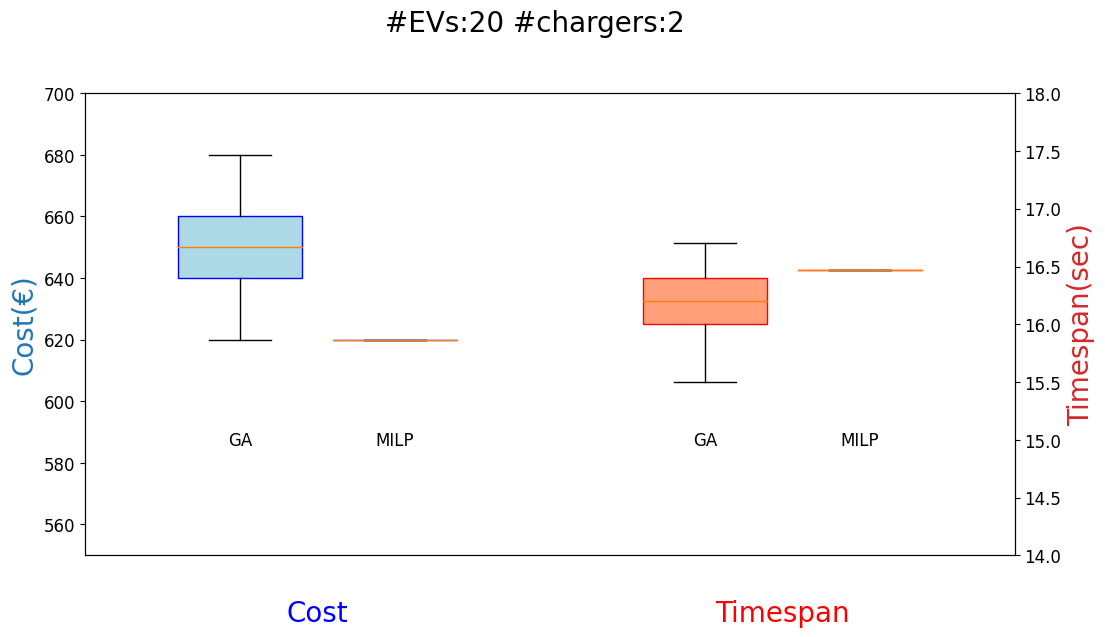

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Datos de ejemplo
algoritmo_genetico_coste = [620,640,650,660,680]
algoritmo_genetico_timespan = [15.5,16.0,16.2,16.4,16.7]

milp_coste = [620] * 10  # Repetir 10 veces el valor 1450
milp_timespan = [16.47] * 10  # Repetir 10 veces el valor 1450

# Configuración del gráfico
fig, ax1 = plt.subplots(figsize=(12, 6))

# Boxplots para el coste en el eje izquierdo
#bp1 = ax1.boxplot([algoritmo_genetico_coste, milp_coste], positions=[1, 2], widths=0.4, patch_artist=True) 'GA', 'MILP'
bp1 = ax1.boxplot([algoritmo_genetico_coste, milp_coste], positions=[1, 1.5], labels=[' ', ' '], widths=0.4, patch_artist=True)

ax1.set_ylabel('Cost(€)', fontsize=20,  color='tab:blue')
ax1.set_ylim([550, 700])  # Ajusta el rango según tus datos

# Colorea los boxplots de coste
colors_coste = ['lightblue', 'lightblue']
for box, color in zip(bp1['boxes'], colors_coste):
    box.set(color='blue', facecolor=color)

# Oculta las etiquetas en el eje x
ax1.tick_params(axis='x', which='both', bottom=False)

# Crear un segundo eje y para timespan en el lado derecho
ax2 = ax1.twinx()
#bp2 = ax2.boxplot([algoritmo_genetico_timespan, milp_timespan], positions=[4, 5], widths=0.4, patch_artist=True)
bp2 = ax2.boxplot([algoritmo_genetico_timespan, milp_timespan], positions=[2.5, 3],labels=[' ', ' '], widths=0.4, patch_artist=True)

ax2.text(2.5, 15, 'GA', ha='center', va='center', fontsize=12, color='black')
ax2.text(3, 15, 'MILP', ha='center', va='center', fontsize=12, color='black')

ax2.text(1, 15, 'GA', ha='center', va='center', fontsize=12, color='black')
ax2.text(1.5, 15, 'MILP', ha='center', va='center', fontsize=12, color='black')

ax2.set_ylabel('Timespan(sec)', fontsize=20,  color='tab:red')
ax2.set_ylim([14, 18])  # Ajusta el rango según tus datos

ax2.text(1.25, 13.5, 'Cost', ha='center', va='center', fontsize=20, color='blue')
ax2.text(2.75, 13.5, 'Timespan', ha='center', va='center', fontsize=20, color='red')

# Colorea los boxplots de timespan
colors_timespan = ['lightsalmon', 'lightsalmon']
for box, color in zip(bp2['boxes'], colors_timespan):
    box.set(color='red', facecolor=color)

# Añadir título superior
plt.suptitle('#EVs:20 #chargers:2', fontsize=20, y=1.02)

# Ajusta el tamaño de las etiquetas de los ejes
ax1.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)

plt.show()



##############################################################
#############################################################



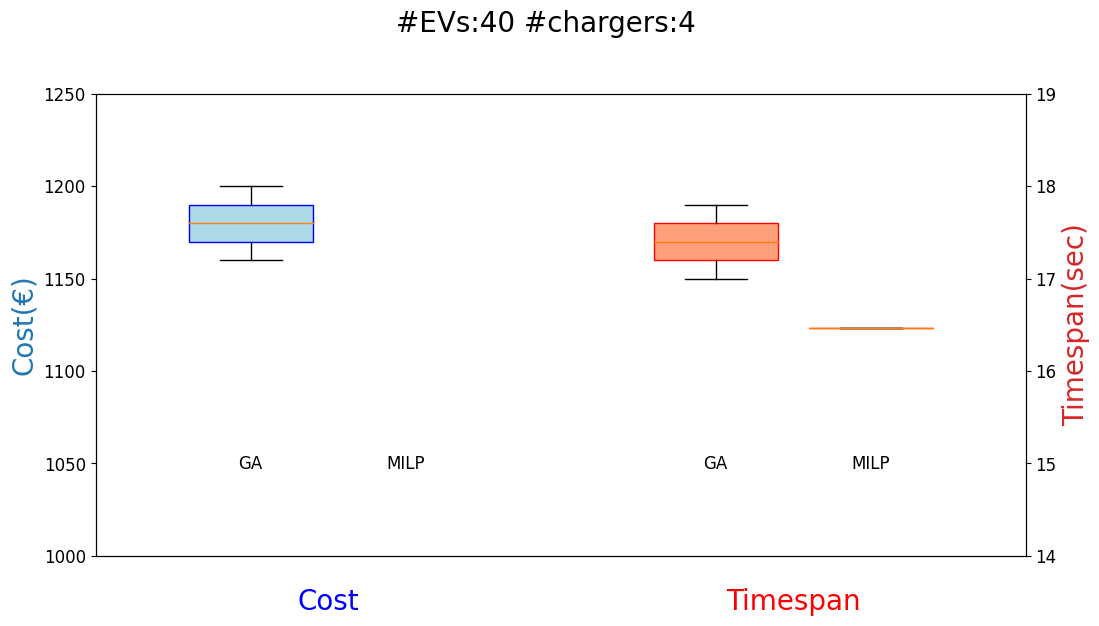

In [ ]:
# Datos de ejemplo
algoritmo_genetico_coste = [1160,1170,1180,1190,1200]
algoritmo_genetico_timespan = [17.0,17.2,17.4,17.6,17.8]

milp_coste = [620] * 10  # Repetir 10 veces el valor 1450
milp_timespan = [16.47] * 10  # Repetir 10 veces el valor 1450

# Configuración del gráfico
fig, ax1 = plt.subplots(figsize=(12, 6))

# Boxplots para el coste en el eje izquierdo
#bp1 = ax1.boxplot([algoritmo_genetico_coste, milp_coste], positions=[1, 2], widths=0.4, patch_artist=True) 'GA', 'MILP'
bp1 = ax1.boxplot([algoritmo_genetico_coste, milp_coste], positions=[1, 1.5], labels=[' ', ' '], widths=0.4, patch_artist=True)

ax1.set_ylabel('Cost(€)', fontsize=20,  color='tab:blue')
ax1.set_ylim([1000, 1250])  # Ajusta el rango según tus datos

# Colorea los boxplots de coste
colors_coste = ['lightblue', 'lightblue']
for box, color in zip(bp1['boxes'], colors_coste):
    box.set(color='blue', facecolor=color)

# Oculta las etiquetas en el eje x
ax1.tick_params(axis='x', which='both', bottom=False)

# Crear un segundo eje y para timespan en el lado derecho
ax2 = ax1.twinx()
#bp2 = ax2.boxplot([algoritmo_genetico_timespan, milp_timespan], positions=[4, 5], widths=0.4, patch_artist=True)
bp2 = ax2.boxplot([algoritmo_genetico_timespan, milp_timespan], positions=[2.5, 3],labels=[' ', ' '], widths=0.4, patch_artist=True)

ax2.text(2.5, 15, 'GA', ha='center', va='center', fontsize=12, color='black')
ax2.text(3, 15, 'MILP', ha='center', va='center', fontsize=12, color='black')

ax2.text(1, 15, 'GA', ha='center', va='center', fontsize=12, color='black')
ax2.text(1.5, 15, 'MILP', ha='center', va='center', fontsize=12, color='black')

ax2.set_ylabel('Timespan(sec)', fontsize=20,  color='tab:red')
ax2.set_ylim([14, 19])  # Ajusta el rango según tus datos

ax2.text(1.25, 13.5, 'Cost', ha='center', va='center', fontsize=20, color='blue')
ax2.text(2.75, 13.5, 'Timespan', ha='center', va='center', fontsize=20, color='red')

# Colorea los boxplots de timespan
colors_timespan = ['lightsalmon', 'lightsalmon']
for box, color in zip(bp2['boxes'], colors_timespan):
    box.set(color='red', facecolor=color)

# Añadir título superior
plt.suptitle('#EVs:40 #chargers:4', fontsize=20, y=1.02)

# Ajusta el tamaño de las etiquetas de los ejes
ax1.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)

plt.show()

# GRAFICA RQ1 VEHICULOS

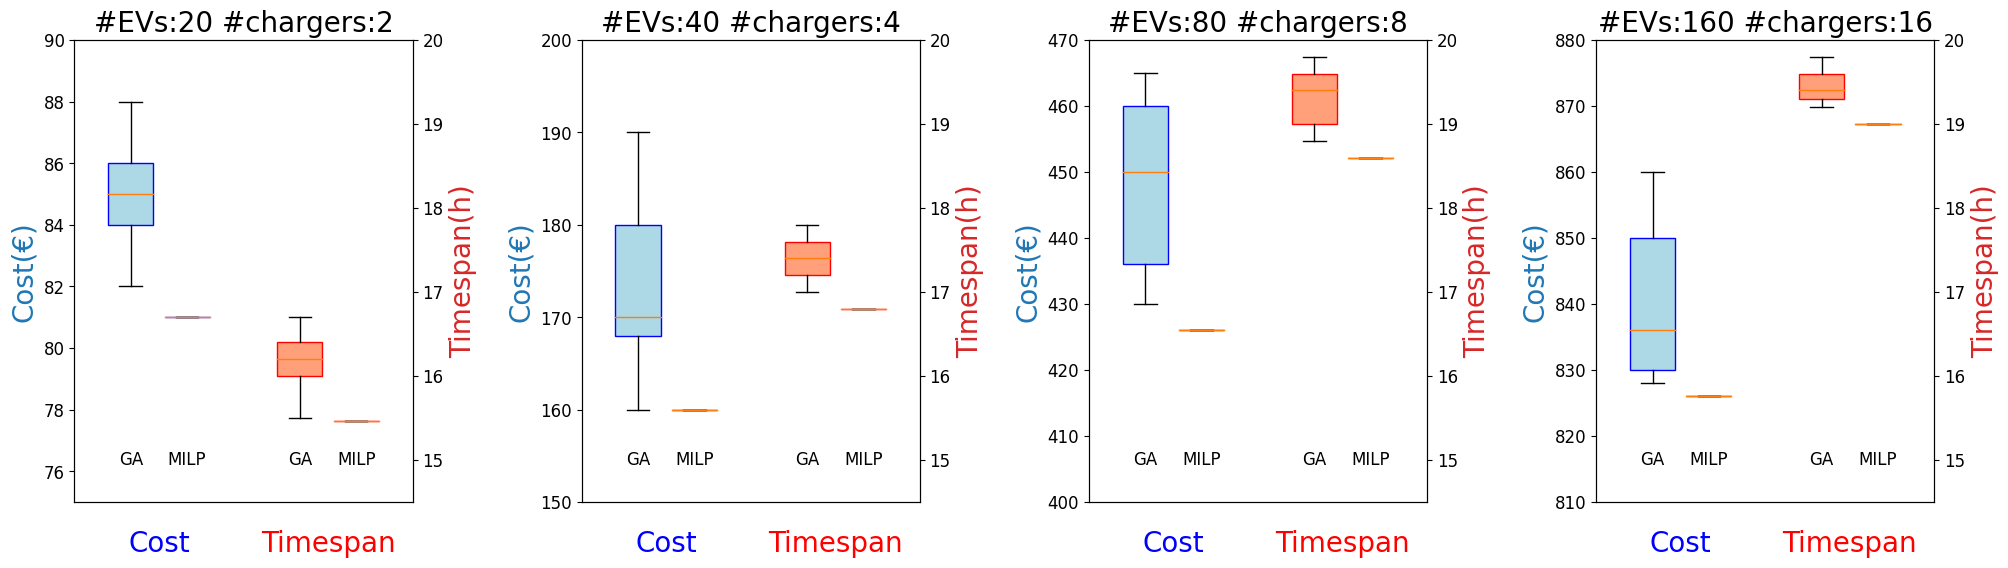

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Datos GRAFICA 1
algoritmo_genetico_coste = [82, 84, 85, 86, 88]
algoritmo_genetico_timespan = [15.5, 16.0, 16.2, 16.4, 16.7]

milp_coste = [81] * 10  # Repetir 10 veces el valor 1450
milp_timespan = [15.47] * 10  # Repetir 10 veces el valor 1450

# Datos GRAFICA 2
algoritmo_genetico_coste2 = [160,170,180,190,168]
algoritmo_genetico_timespan2 = [17.0,17.2,17.4,17.6,17.8]

milp_coste2 = [160] * 10  # Repetir 10 veces el valor 1450
milp_timespan2 = [16.80] * 10  # Repetir 10 veces el valor 1450

# Datos GRAFICA 3
algoritmo_genetico_coste3 = [450,460,436,465,430]
algoritmo_genetico_timespan3 = [18.8,19.0,19.4,19.6,19.8]

milp_coste3 = [426] * 10  # Repetir 10 veces el valor 1450
milp_timespan3 = [18.6] * 10  # Repetir 10 veces el valor 1450

# Datos GRAFICA 3
algoritmo_genetico_coste4 = [850,860,836,830,828]
algoritmo_genetico_timespan4 = [19.3,19.2,19.4,19.6,19.8]

milp_coste4 = [826] * 10  # Repetir 10 veces el valor 1450
milp_timespan4 = [19] * 10  # Repetir 10 veces el valor 1450





# Configuración del gráfico
fig, axs = plt.subplots(1, 4, figsize=(24, 6))
plt.subplots_adjust(wspace=0.5)  # Ajusta el espacio entre las subgráficas

for i, ax in enumerate(axs):

    # Crear un segundo eje y para timespan en el lado derecho
    ax2 = ax.twinx()

    #GRAFICA 1
    if i == 0:
        # Establece límites específicos para el eje y izquierdo en cada gráfica
        ax.set_ylim([75, 90])

        # Boxplots para el coste en el eje izquierdo
        bp1 = ax.boxplot([algoritmo_genetico_coste, milp_coste], positions=[1, 1.5], labels=[' ', ' '], widths=0.4, patch_artist=True)
        bp2 = ax2.boxplot([algoritmo_genetico_timespan, milp_timespan], positions=[2.5, 3], labels=[' ', ' '], widths=0.4, patch_artist=True)

        # Añadir título superior
        ax.set_title('#EVs:20 #chargers:2', fontsize=20)

    #GRAFICA 2
    elif i == 1:
        ax.set_ylim([150, 200])  # Ajusta según tus necesidades

        # Boxplots para el coste en el eje izquierdo
        bp1 = ax.boxplot([algoritmo_genetico_coste2, milp_coste2], positions=[1, 1.5], labels=[' ', ' '], widths=0.4, patch_artist=True)
        bp2 = ax2.boxplot([algoritmo_genetico_timespan2, milp_timespan2], positions=[2.5, 3], labels=[' ', ' '], widths=0.4, patch_artist=True)

        # Añadir título superior
        ax.set_title('#EVs:40 #chargers:4', fontsize=20)

    #GRAFICA 3
    elif i == 2:
        ax.set_ylim([400,470])  # Ajusta según tus necesidades

        # Boxplots para el coste en el eje izquierdo
        bp1 = ax.boxplot([algoritmo_genetico_coste3, milp_coste3], positions=[1, 1.5], labels=[' ', ' '], widths=0.4, patch_artist=True)
        bp2 = ax2.boxplot([algoritmo_genetico_timespan3, milp_timespan3], positions=[2.5, 3], labels=[' ', ' '], widths=0.4, patch_artist=True)

        # Añadir título superior
        ax.set_title('#EVs:80 #chargers:8', fontsize=20)

    #GRAFICA 4
    elif i == 3:
        ax.set_ylim([810,880])  # Ajusta según tus necesidades

        # Boxplots para el coste en el eje izquierdo
        bp1 = ax.boxplot([algoritmo_genetico_coste4, milp_coste4], positions=[1, 1.5], labels=[' ', ' '], widths=0.4, patch_artist=True)
        bp2 = ax2.boxplot([algoritmo_genetico_timespan4, milp_timespan4], positions=[2.5, 3], labels=[' ', ' '], widths=0.4, patch_artist=True)

        # Añadir título superior
        ax.set_title('#EVs:160 #chargers:16', fontsize=20)



    ax.set_ylabel('Cost(€)', fontsize=20, color='tab:blue')

    # Colorea los boxplots de coste
    colors_coste = ['lightblue', 'lightblue']
    for box, color in zip(bp1['boxes'], colors_coste):
        box.set(color='blue', facecolor=color)

    # Ajusta el formato de los ticks en el eje izquierdo
    ax.yaxis.set_major_formatter(plt.FuncFormatter('{:.0f}'.format))

    # Oculta las etiquetas en el eje x
    ax.tick_params(axis='x', which='both', bottom=False)

    ax2.text(2.5, 15, 'GA', ha='center', va='center', fontsize=12, color='black')
    ax2.text(3, 15, 'MILP', ha='center', va='center', fontsize=12, color='black')

    ax2.text(1, 15, 'GA', ha='center', va='center', fontsize=12, color='black')
    ax2.text(1.5, 15, 'MILP', ha='center', va='center', fontsize=12, color='black')

    ax2.set_ylabel('Timespan(h)', fontsize=20, color='tab:red')
    ax2.set_ylim([14.5, 20])  # Ajusta el rango según tus datos

    ax2.text(1.25, 14, 'Cost', ha='center', va='center', fontsize=20, color='blue')
    ax2.text(2.75, 14, 'Timespan', ha='center', va='center', fontsize=20, color='red')

    # Colorea los boxplots de timespan
    colors_timespan = ['lightsalmon', 'lightsalmon']
    for box, color in zip(bp2['boxes'], colors_timespan):
        box.set(color='red', facecolor=color)



    # Ajusta el tamaño de las etiquetas de los ejes
    ax.tick_params(axis='both', labelsize=12)
    ax2.tick_params(axis='both', labelsize=12)


plt.savefig('Grafica_RQ1_Vehiculos.pdf', format='pdf')
plt.show()




# GRAFICA RQ1 ROBOTS

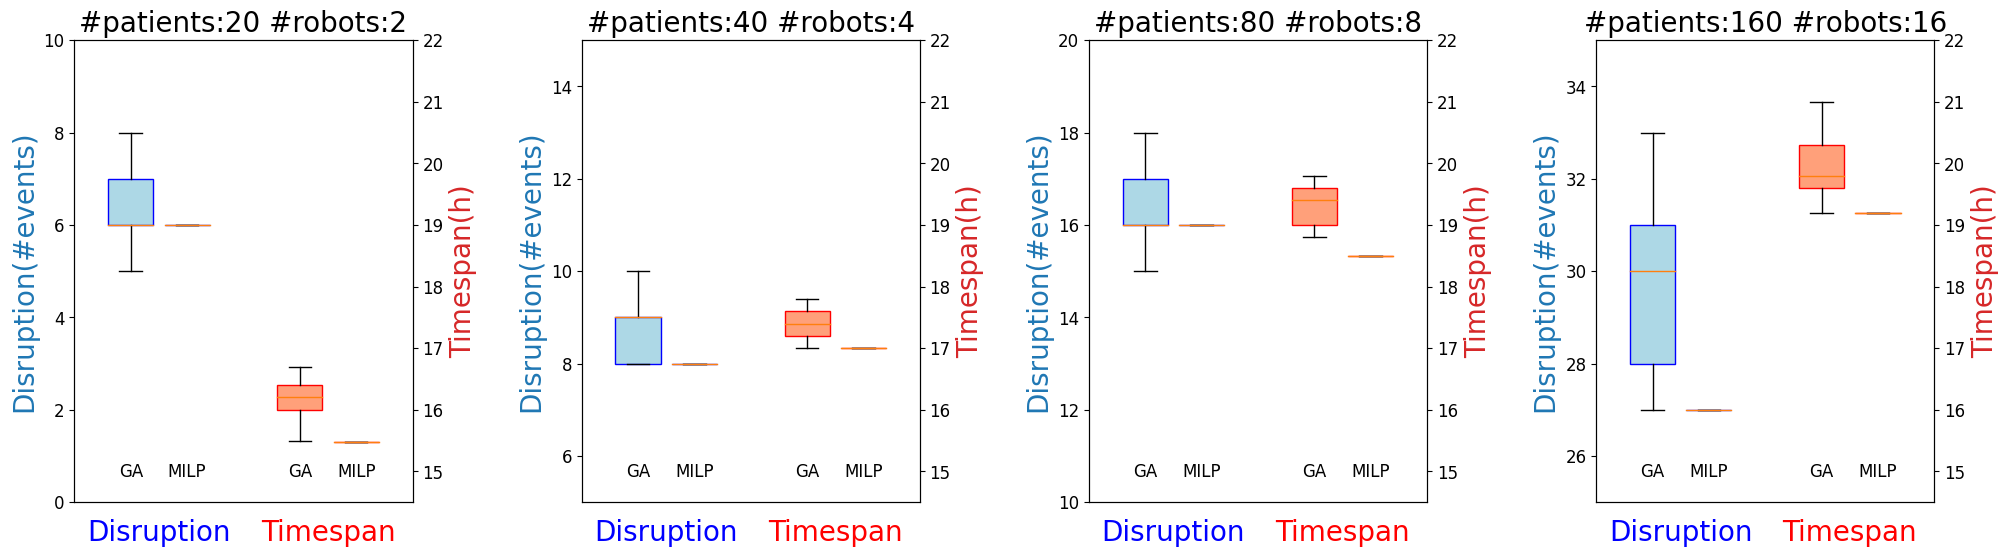

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Datos GRAFICA 1
algoritmo_genetico_coste = [5,6,8,6,7]
algoritmo_genetico_timespan = [15.5, 16.0, 16.2, 16.4, 16.7]

milp_coste = [6] * 10  # Repetir 10 veces el valor 1450
milp_timespan = [15.47] * 10  # Repetir 10 veces el valor 1450

# Datos GRAFICA 2
algoritmo_genetico_coste2 = [8,10,9,8,9]
algoritmo_genetico_timespan2 = [17.0,17.2,17.4,17.6,17.8]

milp_coste2 = [8] * 10  # Repetir 10 veces el valor 1450
milp_timespan2 = [17] * 10  # Repetir 10 veces el valor 1450

# Datos GRAFICA 3
algoritmo_genetico_coste3 = [18,15,16,17,16]
algoritmo_genetico_timespan3 = [18.8,19.0,19.4,19.6,19.8]

milp_coste3 = [16] * 10  # Repetir 10 veces el valor 1450
milp_timespan3 = [18.5] * 10  # Repetir 10 veces el valor 1450

# Datos GRAFICA 3
algoritmo_genetico_coste4 = [31,28,30,33,27]
algoritmo_genetico_timespan4 = [20.3,19.2,21,19.6,19.8]

milp_coste4 = [27] * 10  # Repetir 10 veces el valor 1450
milp_timespan4 = [19.2] * 10  # Repetir 10 veces el valor 1450





# Configuración del gráfico
fig, axs = plt.subplots(1, 4, figsize=(24, 6))
plt.subplots_adjust(wspace=0.5)  # Ajusta el espacio entre las subgráficas

for i, ax in enumerate(axs):

    # Crear un segundo eje y para timespan en el lado derecho
    ax2 = ax.twinx()

    #GRAFICA 1
    if i == 0:
        # Establece límites específicos para el eje y izquierdo en cada gráfica
        ax.set_ylim([0, 10])

        # Boxplots para el coste en el eje izquierdo
        bp1 = ax.boxplot([algoritmo_genetico_coste, milp_coste], positions=[1, 1.5], labels=[' ', ' '], widths=0.4, patch_artist=True)
        bp2 = ax2.boxplot([algoritmo_genetico_timespan, milp_timespan], positions=[2.5, 3], labels=[' ', ' '], widths=0.4, patch_artist=True)

        # Añadir título superior
        ax.set_title('#patients:20 #robots:2', fontsize=20)

    #GRAFICA 2
    elif i == 1:
        ax.set_ylim([5, 15])  # Ajusta según tus necesidades

        # Boxplots para el coste en el eje izquierdo
        bp1 = ax.boxplot([algoritmo_genetico_coste2, milp_coste2], positions=[1, 1.5], labels=[' ', ' '], widths=0.4, patch_artist=True)
        bp2 = ax2.boxplot([algoritmo_genetico_timespan2, milp_timespan2], positions=[2.5, 3], labels=[' ', ' '], widths=0.4, patch_artist=True)

        # Añadir título superior
        ax.set_title('#patients:40 #robots:4', fontsize=20)

    #GRAFICA 3
    elif i == 2:
        ax.set_ylim([10,20])  # Ajusta según tus necesidades

        # Boxplots para el coste en el eje izquierdo
        bp1 = ax.boxplot([algoritmo_genetico_coste3, milp_coste3], positions=[1, 1.5], labels=[' ', ' '], widths=0.4, patch_artist=True)
        bp2 = ax2.boxplot([algoritmo_genetico_timespan3, milp_timespan3], positions=[2.5, 3], labels=[' ', ' '], widths=0.4, patch_artist=True)

        # Añadir título superior
        ax.set_title('#patients:80 #robots:8', fontsize=20)

    #GRAFICA 4
    elif i == 3:
        ax.set_ylim([25,35])  # Ajusta según tus necesidades

        # Boxplots para el coste en el eje izquierdo
        bp1 = ax.boxplot([algoritmo_genetico_coste4, milp_coste4], positions=[1, 1.5], labels=[' ', ' '], widths=0.4, patch_artist=True)
        bp2 = ax2.boxplot([algoritmo_genetico_timespan4, milp_timespan4], positions=[2.5, 3], labels=[' ', ' '], widths=0.4, patch_artist=True)

        # Añadir título superior
        ax.set_title('#patients:160 #robots:16', fontsize=20)



    ax.set_ylabel('Disruption(#events)', fontsize=20, color='tab:blue')

    # Colorea los boxplots de coste
    colors_coste = ['lightblue', 'lightblue']
    for box, color in zip(bp1['boxes'], colors_coste):
        box.set(color='blue', facecolor=color)

    # Ajusta el formato de los ticks en el eje izquierdo
    ax.yaxis.set_major_formatter(plt.FuncFormatter('{:.0f}'.format))

    # Oculta las etiquetas en el eje x
    ax.tick_params(axis='x', which='both', bottom=False)

    ax2.text(2.5, 15, 'GA', ha='center', va='center', fontsize=12, color='black')
    ax2.text(3, 15, 'MILP', ha='center', va='center', fontsize=12, color='black')

    ax2.text(1, 15, 'GA', ha='center', va='center', fontsize=12, color='black')
    ax2.text(1.5, 15, 'MILP', ha='center', va='center', fontsize=12, color='black')

    ax2.set_ylabel('Timespan(h)', fontsize=20, color='tab:red')
    ax2.set_ylim([14.5, 22])  # Ajusta el rango según tus datos

    ax2.text(1.25, 14, 'Disruption', ha='center', va='center', fontsize=20, color='blue')
    ax2.text(2.75, 14, 'Timespan', ha='center', va='center', fontsize=20, color='red')

    # Colorea los boxplots de timespan
    colors_timespan = ['lightsalmon', 'lightsalmon']
    for box, color in zip(bp2['boxes'], colors_timespan):
        box.set(color='red', facecolor=color)



    # Ajusta el tamaño de las etiquetas de los ejes
    ax.tick_params(axis='both', labelsize=12)
    ax2.tick_params(axis='both', labelsize=12)

plt.savefig('Grafica_RQ1_Robots.pdf', format='pdf')
plt.show()

# GRAFICAS RQ1B VEHICULOS

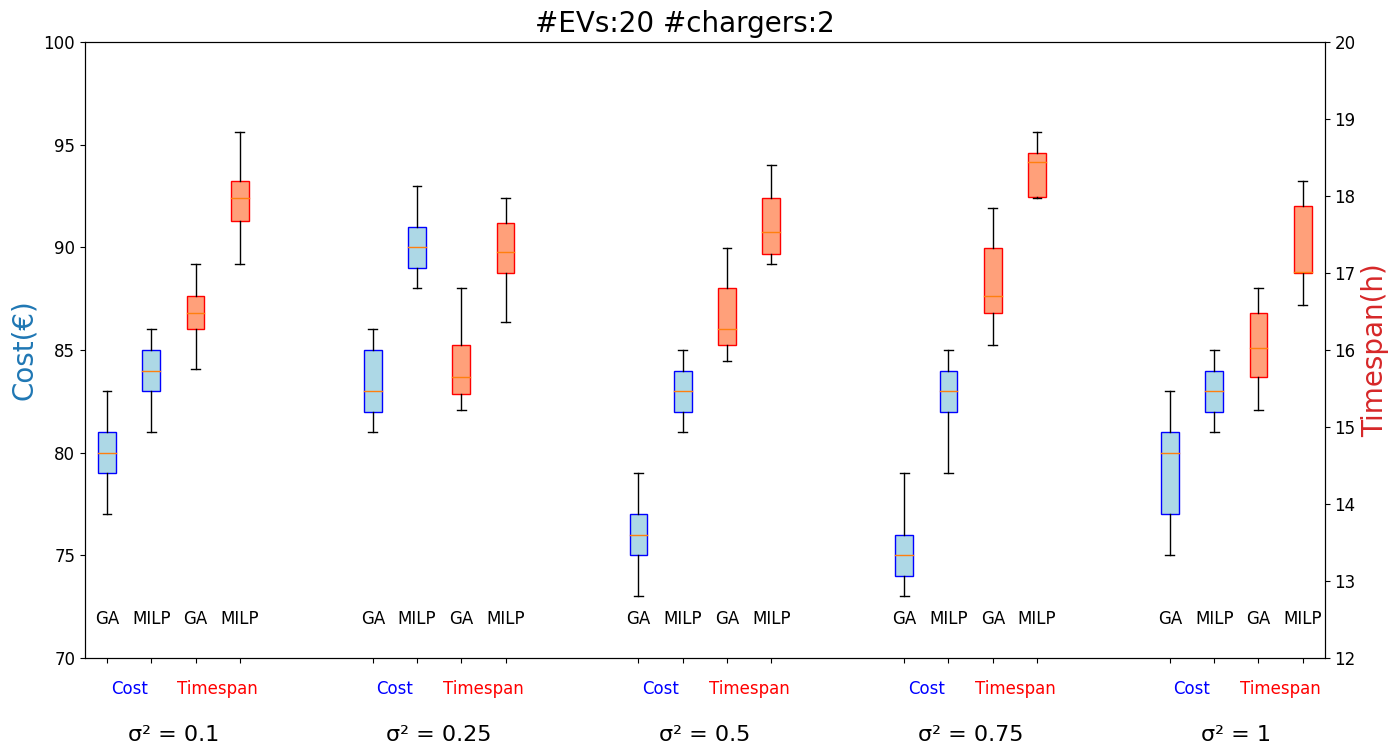

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Datos de ejemplo
num_datasets = 5  # Número de conjuntos de datos
genetico_coste_data = [
    [77, 79, 80, 81, 83],
    [85, 83, 81, 86, 82],
    [73, 79, 77, 75, 76],
    [75, 73, 79, 76, 74],
    [75, 77, 80, 81, 83]
]

milp_coste_data = [
    [83, 85, 84, 81, 86],
    [91, 89, 88, 93, 90],
    [81, 84, 85, 83, 82],
    [84, 79, 85, 83, 82],
    [81, 85, 84, 83, 82]
]

genetico_timespan_data = [
    [15.75, 16.275, 16.485, 16.695, 17.115],
    [16.8, 15.225, 15.435, 15.645, 16.065],
    [17.325, 15.855, 16.275, 16.8, 16.065],
    [17.85, 17.325, 16.485, 16.695, 16.065],
    [16.8, 15.225, 16.485, 15.645, 16.02]
]

milp_timespan_data = [
    [17.12, 17.675, 17.976, 18.19, 18.832],
    [17.655, 16.364, 17.274, 17.976, 16.996],
    [17.976, 18.404, 17.12, 17.535, 17.244],
    [18.832, 17.99, 18.444, 18.558, 17.976],
    [18.19, 16.585, 17.869, 17.013, 16.996]
]

# Configuración del gráfico
fig, axs = plt.subplots(1, 1, figsize=(16, 8))

# Crear un segundo eje y para timespan en el lado derecho
ax2 = axs.twinx()

# Posiciones para los boxplots
positions_genetico_coste = np.arange(1, 3 * num_datasets * 2, step=6)
positions_milp_coste = np.arange(2, 3 * num_datasets * 2 + 1, step=6)

# Boxplots para el coste en el eje izquierdo
bp1 = axs.boxplot(genetico_coste_data, positions=positions_genetico_coste, labels=[f' ' for i in range(num_datasets)], widths=0.4, patch_artist=True)
bp1_milp = axs.boxplot(milp_coste_data, positions=positions_milp_coste, labels=[f' ' for i in range(num_datasets)], widths=0.4, patch_artist=True)

axs.set_ylabel('Cost(€)', fontsize=20, color='tab:blue')
axs.set_ylim([70, 100])  # Ajusta el rango según tus datos

# Colorea los boxplots de coste para genetico
colors_genetico_coste = ['lightblue'] * num_datasets
for box, color in zip(bp1['boxes'], colors_genetico_coste):
    box.set(color='blue', facecolor=color)

# Colorea los boxplots de coste para milp
colors_milp_coste = ['lightblue'] * num_datasets
for box, color in zip(bp1_milp['boxes'], colors_milp_coste):
    box.set(color='blue', facecolor=color)

# Posiciones para los boxplots de timespan
positions_genetico_timespan = np.arange(3, 3 * num_datasets * 2, step=6)
positions_milp_timespan = np.arange(4, 3 * num_datasets * 2 + 1, step=6)

# Boxplots para timespan en el lado derecho
bp2_genetico = ax2.boxplot(genetico_timespan_data, positions=positions_genetico_timespan, labels=[f' ' for i in range(num_datasets)], widths=0.4, patch_artist=True)
bp2_milp = ax2.boxplot(milp_timespan_data, positions=positions_milp_timespan, labels=[f' ' for i in range(num_datasets)], widths=0.4, patch_artist=True)

ax2.set_ylabel('Timespan(h)', fontsize=20, color='tab:red')
ax2.set_ylim([12, 20])  # Ajusta el rango según tus datos

# Colorea los boxplots de timespan para genetico
colors_genetico_timespan = ['lightsalmon'] * num_datasets
for box, color in zip(bp2_genetico['boxes'], colors_genetico_timespan):
    box.set(color='red', facecolor=color)

# Colorea los boxplots de timespan para milp
colors_milp_timespan = ['lightsalmon'] * num_datasets
for box, color in zip(bp2_milp['boxes'], colors_milp_timespan):
    box.set(color='red', facecolor=color)

for i in range(0, 30, 6):
    ax2.text(i+1, 12.5, 'GA', ha='center', va='center', fontsize=12, color='black')
    ax2.text(i+2, 12.5, 'MILP', ha='center', va='center', fontsize=12, color='black')
    ax2.text(i+3, 12.5, 'GA', ha='center', va='center', fontsize=12, color='black')
    ax2.text(i+4, 12.5, 'MILP', ha='center', va='center', fontsize=12, color='black')

for i in range(0, 30, 6):
    ax2.text(i+1.5, 11.6, 'Cost', ha='center', va='center', fontsize=12, color='blue')
    ax2.text(i+3.5, 11.6, 'Timespan', ha='center', va='center', fontsize=12, color='red')

for i in range(0, 30, 6):
    if i==0:
      ax2.text(i+2.5, 11, 'σ² = 0.1', ha='center', va='center', fontsize=16, color='black')
    elif i==6:
      ax2.text(i+2.5, 11, 'σ² = 0.25', ha='center', va='center', fontsize=16, color='black')
    elif i==12:
      ax2.text(i+2.5, 11, 'σ² = 0.5', ha='center', va='center', fontsize=16, color='black')
    elif i==18:
      ax2.text(i+2.5, 11, 'σ² = 0.75', ha='center', va='center', fontsize=16, color='black')
    elif i==24:
      ax2.text(i+2.5, 11, 'σ² = 1', ha='center', va='center', fontsize=16, color='black')

# Añadir título superior
plt.suptitle('#EVs:20 #chargers:2', fontsize=20, y=0.92)

# Ajusta el tamaño de las etiquetas de los ejes
axs.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)

plt.savefig('Grafica_RQ1b_Vehiculos20.pdf', format='pdf')
plt.show()


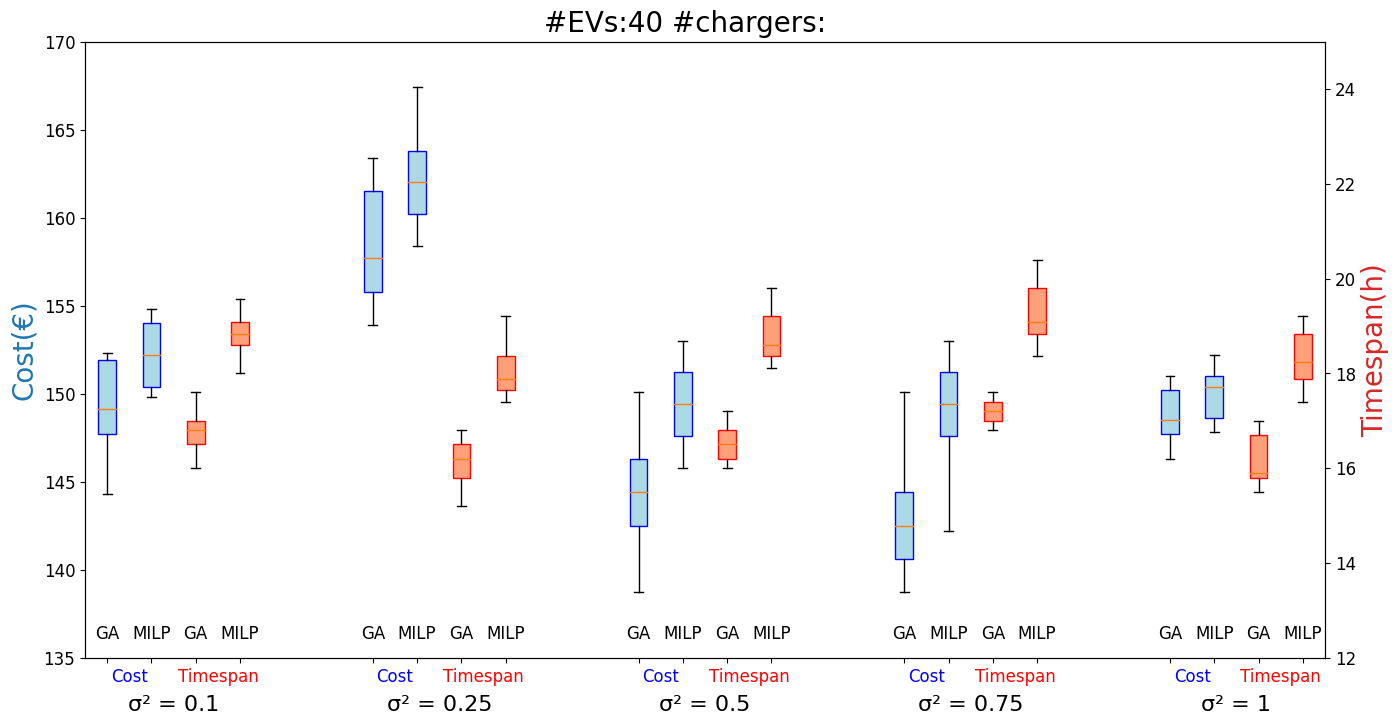

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Datos de ejemplo
num_datasets = 5  # Número de conjuntos de datos
genetico_coste_data = [
    [144.3, 149.1, 152.3, 151.9, 147.7],
    [161.5, 157.7, 153.9, 163.4, 155.8],
    [138.7, 150.1, 146.3, 142.5, 144.4],
    [142.5, 138.7, 150.1, 144.4, 140.6],
    [148.5, 146.3, 151.0, 150.2, 147.7]
]

milp_coste_data = [
    [150.4, 154.0, 152.2, 149.8, 154.8],
    [163.8, 160.2, 158.4, 167.4, 162.0],
    [145.8, 151.2, 153.0, 149.4, 147.6],
    [151.2, 142.2, 153.0, 149.4, 147.6],
    [147.8, 151.0, 152.2, 150.4, 148.6]
]

genetico_timespan_data = [
    [16.0, 16.5, 16.8, 17.0, 17.6],
    [16.5, 15.2, 16.2, 16.8, 15.8],
    [16.8, 17.2, 16.0, 16.5, 16.2],
    [17.6, 17.0, 17.2, 17.4, 16.8],
    [17.0, 15.5, 16.7, 15.9, 15.8]

]

milp_timespan_data = [
    [18.0, 18.6, 18.84, 19.08, 19.56],
    [19.2, 17.4, 17.64, 17.88, 18.36],
    [19.8, 18.12, 18.6, 19.2, 18.36],
    [20.4, 19.8, 18.84, 19.08, 18.36],
    [19.2, 17.4, 18.84, 17.88, 18.24]

]



# Configuración del gráfico
fig, axs = plt.subplots(1, 1, figsize=(16, 8))

# Crear un segundo eje y para timespan en el lado derecho
ax2 = axs.twinx()

# Posiciones para los boxplots
positions_genetico_coste = np.arange(1, 3 * num_datasets * 2, step=6)
positions_milp_coste = np.arange(2, 3 * num_datasets * 2 + 1, step=6)

# Boxplots para el coste en el eje izquierdo
bp1 = axs.boxplot(genetico_coste_data, positions=positions_genetico_coste, labels=[f' ' for i in range(num_datasets)], widths=0.4, patch_artist=True)
bp1_milp = axs.boxplot(milp_coste_data, positions=positions_milp_coste, labels=[f' ' for i in range(num_datasets)], widths=0.4, patch_artist=True)

axs.set_ylabel('Cost(€)', fontsize=20, color='tab:blue')
axs.set_ylim([135, 170])  # Ajusta el rango según tus datos

# Colorea los boxplots de coste para genetico
colors_genetico_coste = ['lightblue'] * num_datasets
for box, color in zip(bp1['boxes'], colors_genetico_coste):
    box.set(color='blue', facecolor=color)

# Colorea los boxplots de coste para milp
colors_milp_coste = ['lightblue'] * num_datasets
for box, color in zip(bp1_milp['boxes'], colors_milp_coste):
    box.set(color='blue', facecolor=color)

# Posiciones para los boxplots de timespan
positions_genetico_timespan = np.arange(3, 3 * num_datasets * 2, step=6)
positions_milp_timespan = np.arange(4, 3 * num_datasets * 2 + 1, step=6)

# Boxplots para timespan en el lado derecho
bp2_genetico = ax2.boxplot(genetico_timespan_data, positions=positions_genetico_timespan, labels=[f' ' for i in range(num_datasets)], widths=0.4, patch_artist=True)
bp2_milp = ax2.boxplot(milp_timespan_data, positions=positions_milp_timespan, labels=[f' ' for i in range(num_datasets)], widths=0.4, patch_artist=True)

ax2.set_ylabel('Timespan(h)', fontsize=20, color='tab:red')
ax2.set_ylim([12, 25])  # Ajusta el rango según tus datos

# Colorea los boxplots de timespan para genetico
colors_genetico_timespan = ['lightsalmon'] * num_datasets
for box, color in zip(bp2_genetico['boxes'], colors_genetico_timespan):
    box.set(color='red', facecolor=color)

# Colorea los boxplots de timespan para milp
colors_milp_timespan = ['lightsalmon'] * num_datasets
for box, color in zip(bp2_milp['boxes'], colors_milp_timespan):
    box.set(color='red', facecolor=color)

for i in range(0, 30, 6):
    ax2.text(i+1, 12.5, 'GA', ha='center', va='center', fontsize=12, color='black')
    ax2.text(i+2, 12.5, 'MILP', ha='center', va='center', fontsize=12, color='black')
    ax2.text(i+3, 12.5, 'GA', ha='center', va='center', fontsize=12, color='black')
    ax2.text(i+4, 12.5, 'MILP', ha='center', va='center', fontsize=12, color='black')

for i in range(0, 30, 6):
    ax2.text(i+1.5, 11.6, 'Cost', ha='center', va='center', fontsize=12, color='blue')
    ax2.text(i+3.5, 11.6, 'Timespan', ha='center', va='center', fontsize=12, color='red')

for i in range(0, 30, 6):
    if i==0:
      ax2.text(i+2.5, 11, 'σ² = 0.1', ha='center', va='center', fontsize=16, color='black')
    elif i==6:
      ax2.text(i+2.5, 11, 'σ² = 0.25', ha='center', va='center', fontsize=16, color='black')
    elif i==12:
      ax2.text(i+2.5, 11, 'σ² = 0.5', ha='center', va='center', fontsize=16, color='black')
    elif i==18:
      ax2.text(i+2.5, 11, 'σ² = 0.75', ha='center', va='center', fontsize=16, color='black')
    elif i==24:
      ax2.text(i+2.5, 11, 'σ² = 1', ha='center', va='center', fontsize=16, color='black')

# Añadir título superior
plt.suptitle('#EVs:40 #chargers:', fontsize=20, y=0.92)

# Ajusta el tamaño de las etiquetas de los ejes
axs.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)

plt.savefig('Grafica_RQ1b_Vehiculos40.pdf', format='pdf')
plt.show()

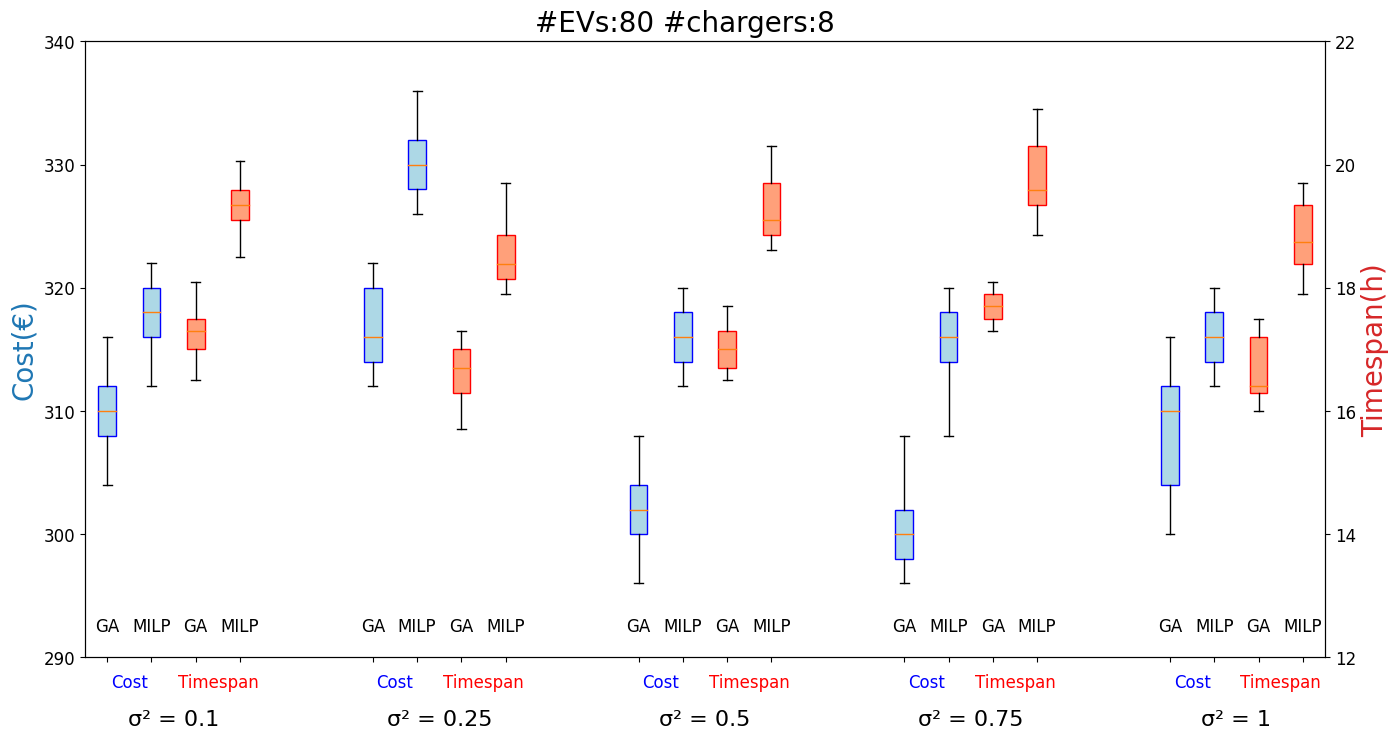

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Datos de ejemplo
num_datasets = 5  # Número de conjuntos de datos
genetico_coste_data = [
    [304, 308, 310, 312, 316],
    [320, 316, 312, 322, 314],
    [296, 308, 304, 300, 302],
    [300, 296, 308, 302, 298],
    [300, 304, 310, 312, 316]
]

milp_coste_data = [
    [316, 320, 318, 312, 322],
    [332, 328, 326, 336, 330],
    [312, 318, 320, 316, 314],
    [318, 308, 320, 316, 314],
    [312, 320, 318, 316, 314]
]

genetico_timespan_data = [
    [16.5, 17.0, 17.3, 17.5, 18.1],
    [17.0, 15.7, 16.7, 17.3, 16.3],
    [17.3, 17.7, 16.5, 17.0, 16.7],
    [18.1, 17.5, 17.7, 17.9, 17.3],
    [17.5, 16.0, 17.2, 16.4, 16.3]
]

milp_timespan_data = [
    [18.5, 19.1, 19.34, 19.58, 20.06],
    [19.7, 17.9, 18.14, 18.38, 18.86],
    [20.3, 18.62, 19.1, 19.7, 18.86],
    [20.9, 20.3, 19.34, 19.58, 18.86],
    [19.7, 17.9, 19.34, 18.38, 18.74]
]

# Configuración del gráfico
fig, axs = plt.subplots(1, 1, figsize=(16, 8))

# Crear un segundo eje y para timespan en el lado derecho
ax2 = axs.twinx()

# Posiciones para los boxplots
positions_genetico_coste = np.arange(1, 3 * num_datasets * 2, step=6)
positions_milp_coste = np.arange(2, 3 * num_datasets * 2 + 1, step=6)

# Boxplots para el coste en el eje izquierdo
bp1 = axs.boxplot(genetico_coste_data, positions=positions_genetico_coste, labels=[f' ' for i in range(num_datasets)], widths=0.4, patch_artist=True)
bp1_milp = axs.boxplot(milp_coste_data, positions=positions_milp_coste, labels=[f' ' for i in range(num_datasets)], widths=0.4, patch_artist=True)

axs.set_ylabel('Cost(€)', fontsize=20, color='tab:blue')
axs.set_ylim([290, 340])  # Ajusta el rango según tus datos

# Colorea los boxplots de coste para genetico
colors_genetico_coste = ['lightblue'] * num_datasets
for box, color in zip(bp1['boxes'], colors_genetico_coste):
    box.set(color='blue', facecolor=color)

# Colorea los boxplots de coste para milp
colors_milp_coste = ['lightblue'] * num_datasets
for box, color in zip(bp1_milp['boxes'], colors_milp_coste):
    box.set(color='blue', facecolor=color)

# Posiciones para los boxplots de timespan
positions_genetico_timespan = np.arange(3, 3 * num_datasets * 2, step=6)
positions_milp_timespan = np.arange(4, 3 * num_datasets * 2 + 1, step=6)

# Boxplots para timespan en el lado derecho
bp2_genetico = ax2.boxplot(genetico_timespan_data, positions=positions_genetico_timespan, labels=[f' ' for i in range(num_datasets)], widths=0.4, patch_artist=True)
bp2_milp = ax2.boxplot(milp_timespan_data, positions=positions_milp_timespan, labels=[f' ' for i in range(num_datasets)], widths=0.4, patch_artist=True)

ax2.set_ylabel('Timespan(h)', fontsize=20, color='tab:red')
ax2.set_ylim([12, 22])  # Ajusta el rango según tus datos

# Colorea los boxplots de timespan para genetico
colors_genetico_timespan = ['lightsalmon'] * num_datasets
for box, color in zip(bp2_genetico['boxes'], colors_genetico_timespan):
    box.set(color='red', facecolor=color)

# Colorea los boxplots de timespan para milp
colors_milp_timespan = ['lightsalmon'] * num_datasets
for box, color in zip(bp2_milp['boxes'], colors_milp_timespan):
    box.set(color='red', facecolor=color)

for i in range(0, 30, 6):
    ax2.text(i+1, 12.5, 'GA', ha='center', va='center', fontsize=12, color='black')
    ax2.text(i+2, 12.5, 'MILP', ha='center', va='center', fontsize=12, color='black')
    ax2.text(i+3, 12.5, 'GA', ha='center', va='center', fontsize=12, color='black')
    ax2.text(i+4, 12.5, 'MILP', ha='center', va='center', fontsize=12, color='black')

for i in range(0, 30, 6):
    ax2.text(i+1.5, 11.6, 'Cost', ha='center', va='center', fontsize=12, color='blue')
    ax2.text(i+3.5, 11.6, 'Timespan', ha='center', va='center', fontsize=12, color='red')

for i in range(0, 30, 6):
    if i==0:
      ax2.text(i+2.5, 11, 'σ² = 0.1', ha='center', va='center', fontsize=16, color='black')
    elif i==6:
      ax2.text(i+2.5, 11, 'σ² = 0.25', ha='center', va='center', fontsize=16, color='black')
    elif i==12:
      ax2.text(i+2.5, 11, 'σ² = 0.5', ha='center', va='center', fontsize=16, color='black')
    elif i==18:
      ax2.text(i+2.5, 11, 'σ² = 0.75', ha='center', va='center', fontsize=16, color='black')
    elif i==24:
      ax2.text(i+2.5, 11, 'σ² = 1', ha='center', va='center', fontsize=16, color='black')

# Añadir título superior
plt.suptitle('#EVs:80 #chargers:8', fontsize=20, y=0.92)

# Ajusta el tamaño de las etiquetas de los ejes
axs.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)

plt.savefig('Grafica_R1b_Vehiculos80.pdf', format='pdf')
plt.show()

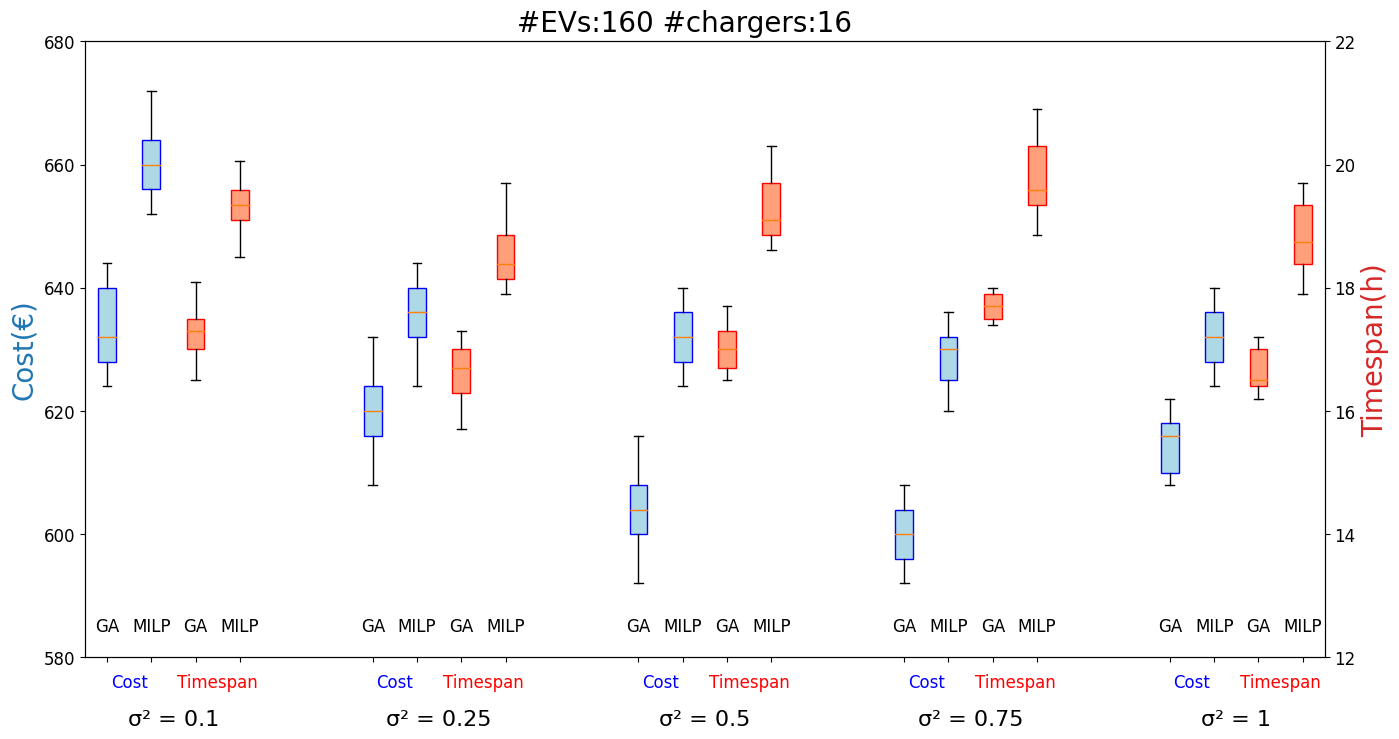

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Datos de ejemplo
num_datasets = 5  # Número de conjuntos de datos
genetico_coste_data = [
    [640, 632, 624, 644, 628],
    [608, 616, 620, 624, 632],
    [592, 616, 608, 600, 604],
    [600, 592, 608, 604, 596],
    [610, 608, 616, 618, 622]
]

milp_coste_data = [
    [664, 656, 652, 672, 660],
    [632, 640, 636, 624, 644],
    [624, 636, 640, 632, 628],
    [636, 620, 630, 632, 625],
    [624, 640, 636, 632, 628]
]

genetico_timespan_data = [
    [16.5, 17.0, 17.3, 17.5, 18.1],
    [17.0, 15.7, 16.7, 17.3, 16.3],
    [17.3, 17.7, 16.5, 17.0, 16.7],
    [18.0, 17.5, 17.7, 17.9, 17.4],
    [17.2, 16.2, 17, 16.4, 16.5]
]

milp_timespan_data = [
    [18.5, 19.1, 19.34, 19.58, 20.06],
    [19.7, 17.9, 18.14, 18.38, 18.86],
    [20.3, 18.62, 19.1, 19.7, 18.86],
    [20.9, 20.3, 19.34, 19.58, 18.86],
    [19.7, 17.9, 19.34, 18.38, 18.74]
]

# Configuración del gráfico
fig, axs = plt.subplots(1, 1, figsize=(16, 8))

# Crear un segundo eje y para timespan en el lado derecho
ax2 = axs.twinx()

# Posiciones para los boxplots
positions_genetico_coste = np.arange(1, 3 * num_datasets * 2, step=6)
positions_milp_coste = np.arange(2, 3 * num_datasets * 2 + 1, step=6)

# Boxplots para el coste en el eje izquierdo
bp1 = axs.boxplot(genetico_coste_data, positions=positions_genetico_coste, labels=[f' ' for i in range(num_datasets)], widths=0.4, patch_artist=True)
bp1_milp = axs.boxplot(milp_coste_data, positions=positions_milp_coste, labels=[f' ' for i in range(num_datasets)], widths=0.4, patch_artist=True)

axs.set_ylabel('Cost(€)', fontsize=20, color='tab:blue')
axs.set_ylim([580, 680])  # Ajusta el rango según tus datos

# Colorea los boxplots de coste para genetico
colors_genetico_coste = ['lightblue'] * num_datasets
for box, color in zip(bp1['boxes'], colors_genetico_coste):
    box.set(color='blue', facecolor=color)

# Colorea los boxplots de coste para milp
colors_milp_coste = ['lightblue'] * num_datasets
for box, color in zip(bp1_milp['boxes'], colors_milp_coste):
    box.set(color='blue', facecolor=color)

# Posiciones para los boxplots de timespan
positions_genetico_timespan = np.arange(3, 3 * num_datasets * 2, step=6)
positions_milp_timespan = np.arange(4, 3 * num_datasets * 2 + 1, step=6)

# Boxplots para timespan en el lado derecho
bp2_genetico = ax2.boxplot(genetico_timespan_data, positions=positions_genetico_timespan, labels=[f' ' for i in range(num_datasets)], widths=0.4, patch_artist=True)
bp2_milp = ax2.boxplot(milp_timespan_data, positions=positions_milp_timespan, labels=[f' ' for i in range(num_datasets)], widths=0.4, patch_artist=True)

ax2.set_ylabel('Timespan(h)', fontsize=20, color='tab:red')
ax2.set_ylim([12, 22])  # Ajusta el rango según tus datos

# Colorea los boxplots de timespan para genetico
colors_genetico_timespan = ['lightsalmon'] * num_datasets
for box, color in zip(bp2_genetico['boxes'], colors_genetico_timespan):
    box.set(color='red', facecolor=color)

# Colorea los boxplots de timespan para milp
colors_milp_timespan = ['lightsalmon'] * num_datasets
for box, color in zip(bp2_milp['boxes'], colors_milp_timespan):
    box.set(color='red', facecolor=color)

for i in range(0, 30, 6):
    ax2.text(i+1, 12.5, 'GA', ha='center', va='center', fontsize=12, color='black')
    ax2.text(i+2, 12.5, 'MILP', ha='center', va='center', fontsize=12, color='black')
    ax2.text(i+3, 12.5, 'GA', ha='center', va='center', fontsize=12, color='black')
    ax2.text(i+4, 12.5, 'MILP', ha='center', va='center', fontsize=12, color='black')

for i in range(0, 30, 6):
    ax2.text(i+1.5, 11.6, 'Cost', ha='center', va='center', fontsize=12, color='blue')
    ax2.text(i+3.5, 11.6, 'Timespan', ha='center', va='center', fontsize=12, color='red')

for i in range(0, 30, 6):
    if i==0:
      ax2.text(i+2.5, 11, 'σ² = 0.1', ha='center', va='center', fontsize=16, color='black')
    elif i==6:
      ax2.text(i+2.5, 11, 'σ² = 0.25', ha='center', va='center', fontsize=16, color='black')
    elif i==12:
      ax2.text(i+2.5, 11, 'σ² = 0.5', ha='center', va='center', fontsize=16, color='black')
    elif i==18:
      ax2.text(i+2.5, 11, 'σ² = 0.75', ha='center', va='center', fontsize=16, color='black')
    elif i==24:
      ax2.text(i+2.5, 11, 'σ² = 1', ha='center', va='center', fontsize=16, color='black')

# Añadir título superior
plt.suptitle('#EVs:160 #chargers:16', fontsize=20, y=0.92)

# Ajusta el tamaño de las etiquetas de los ejes
axs.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)

plt.savefig('Grafica_RQ1b_Vehiculos160.pdf', format='pdf')
plt.show()

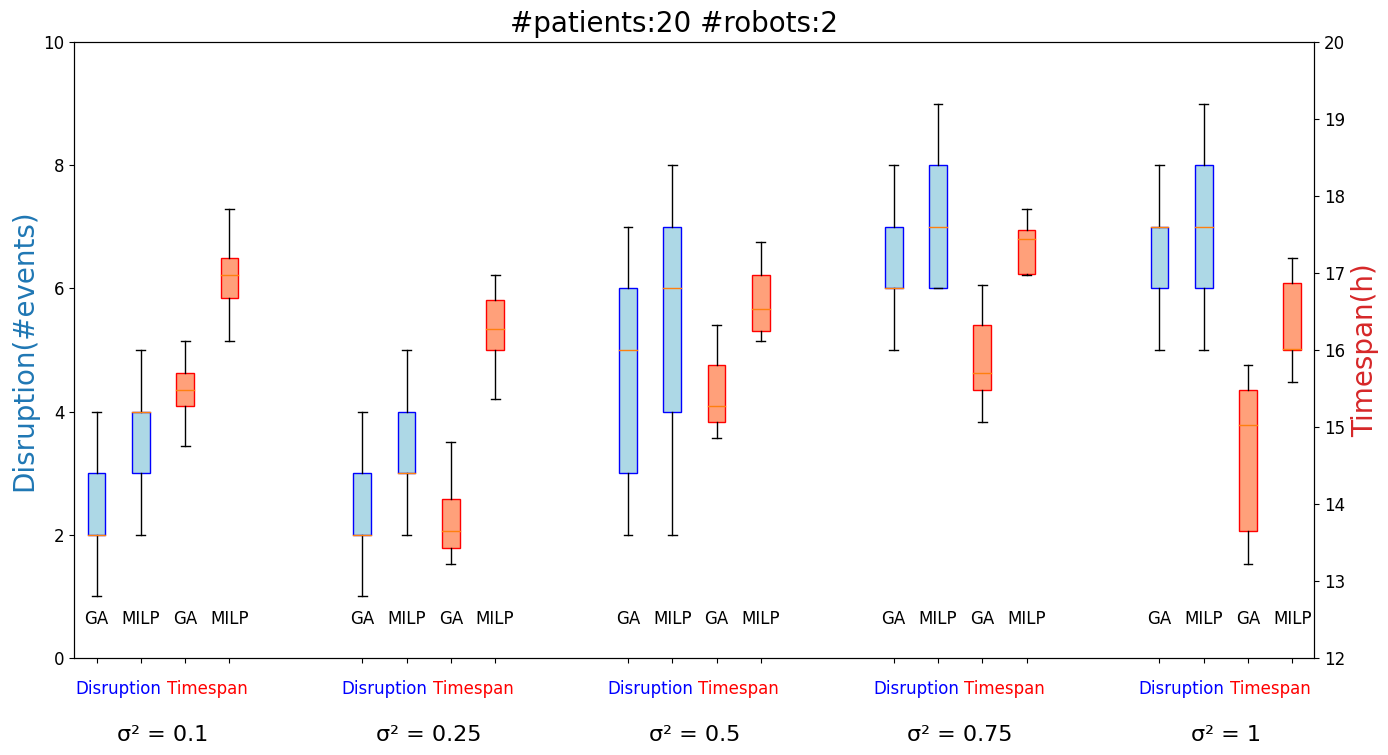

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Datos de ejemplo
num_datasets = 5  # Número de conjuntos de datos
genetico_coste_data = [
    [2,4,3,2,1],
    [3,4,1,2,2],
    [2,3,5,6,7],
    [5,6,8,6,7],
    [7,6,8,5,7]
]

milp_coste_data = [
    [3, 4, 4, 2, 5],
    [3, 4, 5, 2, 3],
    [2, 4, 8, 6, 7],
    [7, 6, 9, 6, 8],
    [7, 6, 8, 5, 9]
]

'''
genetico_timespan_data = [
    [15.75, 16.275, 16.485, 16.695, 17.115],
    [16.8, 15.225, 15.435, 15.645, 16.065],
    [17.325, 15.855, 16.275, 16.8, 16.065],
    [17.85, 17.325, 16.485, 16.695, 16.065],
    [16.8, 15.225, 16.485, 15.645, 16.02]
]

milp_timespan_data = [
    [17.12, 17.675, 17.976, 18.19, 18.832],
    [17.655, 16.364, 17.274, 17.976, 16.996],
    [17.976, 18.404, 17.12, 17.535, 17.244],
    [18.832, 17.99, 18.444, 18.558, 17.976],
    [18.19, 16.585, 17.869, 17.013, 16.996]
]'''

genetico_timespan_data = [
    [14.75, 15.275, 15.485, 15.695, 16.115],
    [14.8, 13.225, 13.435, 13.645, 14.065],
    [16.325, 14.855, 15.275, 15.8, 15.065],
    [16.85, 16.325, 15.485, 15.695, 15.065],
    [15.8, 13.225, 15.485, 13.645, 15.02]
]

milp_timespan_data = [
    [16.12, 16.675, 16.976, 17.19, 17.832],
    [16.655, 15.364, 16.274, 16.976, 15.996],
    [16.976, 17.404, 16.12, 16.535, 16.244],
    [17.832, 16.99, 17.444, 17.558, 16.976],
    [17.19, 15.585, 16.869, 16.013, 15.996]
]

# Configuración del gráfico
fig, axs = plt.subplots(1, 1, figsize=(16, 8))

# Crear un segundo eje y para timespan en el lado derecho
ax2 = axs.twinx()

# Posiciones para los boxplots
positions_genetico_coste = np.arange(1, 3 * num_datasets * 2, step=6)
positions_milp_coste = np.arange(2, 3 * num_datasets * 2 + 1, step=6)

# Boxplots para el coste en el eje izquierdo
bp1 = axs.boxplot(genetico_coste_data, positions=positions_genetico_coste, labels=[f' ' for i in range(num_datasets)], widths=0.4, patch_artist=True)
bp1_milp = axs.boxplot(milp_coste_data, positions=positions_milp_coste, labels=[f' ' for i in range(num_datasets)], widths=0.4, patch_artist=True)

axs.set_ylabel('Disruption(#events)', fontsize=20, color='tab:blue')
axs.set_ylim([0, 10])  # Ajusta el rango según tus datos

# Colorea los boxplots de coste para genetico
colors_genetico_coste = ['lightblue'] * num_datasets
for box, color in zip(bp1['boxes'], colors_genetico_coste):
    box.set(color='blue', facecolor=color)

# Colorea los boxplots de coste para milp
colors_milp_coste = ['lightblue'] * num_datasets
for box, color in zip(bp1_milp['boxes'], colors_milp_coste):
    box.set(color='blue', facecolor=color)

# Posiciones para los boxplots de timespan
positions_genetico_timespan = np.arange(3, 3 * num_datasets * 2, step=6)
positions_milp_timespan = np.arange(4, 3 * num_datasets * 2 + 1, step=6)

# Boxplots para timespan en el lado derecho
bp2_genetico = ax2.boxplot(genetico_timespan_data, positions=positions_genetico_timespan, labels=[f' ' for i in range(num_datasets)], widths=0.4, patch_artist=True)
bp2_milp = ax2.boxplot(milp_timespan_data, positions=positions_milp_timespan, labels=[f' ' for i in range(num_datasets)], widths=0.4, patch_artist=True)

ax2.set_ylabel('Timespan(h)', fontsize=20, color='tab:red')
ax2.set_ylim([12, 20])  # Ajusta el rango según tus datos

# Colorea los boxplots de timespan para genetico
colors_genetico_timespan = ['lightsalmon'] * num_datasets
for box, color in zip(bp2_genetico['boxes'], colors_genetico_timespan):
    box.set(color='red', facecolor=color)

# Colorea los boxplots de timespan para milp
colors_milp_timespan = ['lightsalmon'] * num_datasets
for box, color in zip(bp2_milp['boxes'], colors_milp_timespan):
    box.set(color='red', facecolor=color)

for i in range(0, 30, 6):
    ax2.text(i+1, 12.5, 'GA', ha='center', va='center', fontsize=12, color='black')
    ax2.text(i+2, 12.5, 'MILP', ha='center', va='center', fontsize=12, color='black')
    ax2.text(i+3, 12.5, 'GA', ha='center', va='center', fontsize=12, color='black')
    ax2.text(i+4, 12.5, 'MILP', ha='center', va='center', fontsize=12, color='black')

for i in range(0, 30, 6):
    ax2.text(i+1.5, 11.6, 'Disruption', ha='center', va='center', fontsize=12, color='blue')
    ax2.text(i+3.5, 11.6, 'Timespan', ha='center', va='center', fontsize=12, color='red')

for i in range(0, 30, 6):
    if i==0:
      ax2.text(i+2.5, 11, 'σ² = 0.1', ha='center', va='center', fontsize=16, color='black')
    elif i==6:
      ax2.text(i+2.5, 11, 'σ² = 0.25', ha='center', va='center', fontsize=16, color='black')
    elif i==12:
      ax2.text(i+2.5, 11, 'σ² = 0.5', ha='center', va='center', fontsize=16, color='black')
    elif i==18:
      ax2.text(i+2.5, 11, 'σ² = 0.75', ha='center', va='center', fontsize=16, color='black')
    elif i==24:
      ax2.text(i+2.5, 11, 'σ² = 1', ha='center', va='center', fontsize=16, color='black')

# Añadir título superior
plt.suptitle('#patients:20 #robots:2', fontsize=20, y=0.92)

# Ajusta el tamaño de las etiquetas de los ejes
axs.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)

plt.savefig('Grafica_RQ1b_Robots20.pdf', format='pdf')
plt.show()

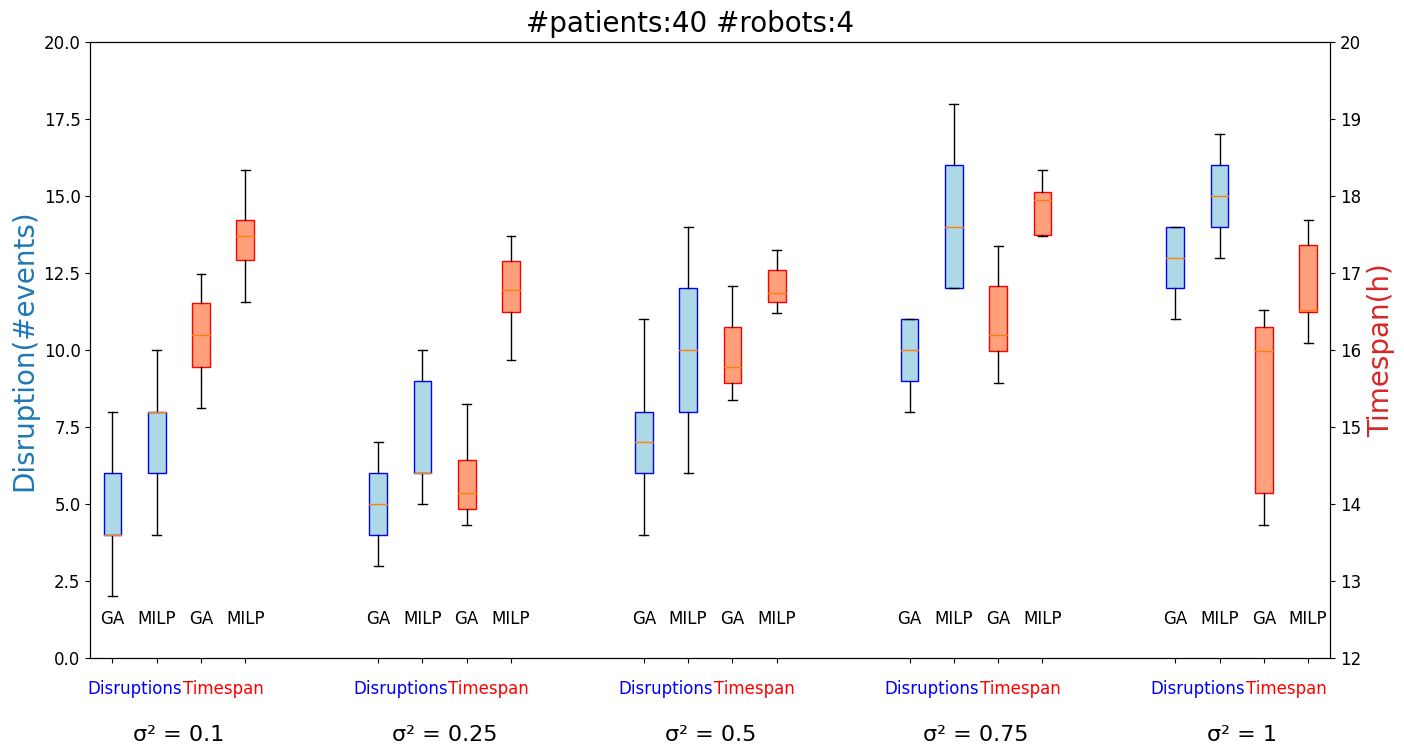

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Datos de ejemplo
num_datasets = 5  # Número de conjuntos de datos
genetico_coste_data = [
    [4, 8, 6, 4, 2],
    [6, 5, 3, 7, 4],
    [4, 6, 8, 11, 7],
    [9, 10, 11, 8, 11],
    [12, 13, 14, 11, 14]
]

milp_coste_data = [
    [6, 8, 8, 4, 10],
    [6, 9, 10, 5, 6],
    [6, 8, 10, 12, 14],
    [14, 12, 18, 12, 16],
    [14, 17, 16, 13, 15]
]


'''
genetico_timespan_data = [
    [15.75, 16.275, 16.485, 16.695, 17.115],
    [16.8, 15.225, 15.435, 15.645, 16.065],
    [17.325, 15.855, 16.275, 16.8, 16.065],
    [17.85, 17.325, 16.485, 16.695, 16.065],
    [16.8, 15.225, 16.485, 15.645, 16.02]
]

milp_timespan_data = [
    [17.12, 17.675, 17.976, 18.19, 18.832],
    [17.655, 16.364, 17.274, 17.976, 16.996],
    [17.976, 18.404, 17.12, 17.535, 17.244],
    [18.832, 17.99, 18.444, 18.558, 17.976],
    [18.19, 16.585, 17.869, 17.013, 16.996]
]'''

genetico_timespan_data = [
    [15.25, 15.775, 16.985, 16.195, 16.615],
    [15.3, 13.725, 13.935, 14.145, 14.565],
    [16.825, 15.355, 15.775, 16.3, 15.565],
    [17.35, 16.825, 15.985, 16.195, 15.565],
    [16.3, 13.725, 15.985, 14.145, 16.52]
]

milp_timespan_data = [
    [16.62, 17.175, 17.476, 17.69, 18.332],
    [17.155, 15.864, 16.774, 17.476, 16.496],
    [16.476, 17.304, 16.62, 17.035, 16.744],
    [18.332, 17.49, 17.944, 18.058, 17.476],
    [17.69, 16.085, 17.369, 16.513, 16.496]
]

# Configuración del gráfico
fig, axs = plt.subplots(1, 1, figsize=(16, 8))

# Crear un segundo eje y para timespan en el lado derecho
ax2 = axs.twinx()

# Posiciones para los boxplots
positions_genetico_coste = np.arange(1, 3 * num_datasets * 2, step=6)
positions_milp_coste = np.arange(2, 3 * num_datasets * 2 + 1, step=6)

# Boxplots para el coste en el eje izquierdo
bp1 = axs.boxplot(genetico_coste_data, positions=positions_genetico_coste, labels=[f' ' for i in range(num_datasets)], widths=0.4, patch_artist=True)
bp1_milp = axs.boxplot(milp_coste_data, positions=positions_milp_coste, labels=[f' ' for i in range(num_datasets)], widths=0.4, patch_artist=True)

axs.set_ylabel('Disruption(#events)', fontsize=20, color='tab:blue')
axs.set_ylim([0, 20])  # Ajusta el rango según tus datos

# Colorea los boxplots de coste para genetico
colors_genetico_coste = ['lightblue'] * num_datasets
for box, color in zip(bp1['boxes'], colors_genetico_coste):
    box.set(color='blue', facecolor=color)

# Colorea los boxplots de coste para milp
colors_milp_coste = ['lightblue'] * num_datasets
for box, color in zip(bp1_milp['boxes'], colors_milp_coste):
    box.set(color='blue', facecolor=color)

# Posiciones para los boxplots de timespan
positions_genetico_timespan = np.arange(3, 3 * num_datasets * 2, step=6)
positions_milp_timespan = np.arange(4, 3 * num_datasets * 2 + 1, step=6)

# Boxplots para timespan en el lado derecho
bp2_genetico = ax2.boxplot(genetico_timespan_data, positions=positions_genetico_timespan, labels=[f' ' for i in range(num_datasets)], widths=0.4, patch_artist=True)
bp2_milp = ax2.boxplot(milp_timespan_data, positions=positions_milp_timespan, labels=[f' ' for i in range(num_datasets)], widths=0.4, patch_artist=True)

ax2.set_ylabel('Timespan(h)', fontsize=20, color='tab:red')
ax2.set_ylim([12, 20])  # Ajusta el rango según tus datos

# Colorea los boxplots de timespan para genetico
colors_genetico_timespan = ['lightsalmon'] * num_datasets
for box, color in zip(bp2_genetico['boxes'], colors_genetico_timespan):
    box.set(color='red', facecolor=color)

# Colorea los boxplots de timespan para milp
colors_milp_timespan = ['lightsalmon'] * num_datasets
for box, color in zip(bp2_milp['boxes'], colors_milp_timespan):
    box.set(color='red', facecolor=color)

for i in range(0, 30, 6):
    ax2.text(i+1, 12.5, 'GA', ha='center', va='center', fontsize=12, color='black')
    ax2.text(i+2, 12.5, 'MILP', ha='center', va='center', fontsize=12, color='black')
    ax2.text(i+3, 12.5, 'GA', ha='center', va='center', fontsize=12, color='black')
    ax2.text(i+4, 12.5, 'MILP', ha='center', va='center', fontsize=12, color='black')

for i in range(0, 30, 6):
    ax2.text(i+1.5, 11.6, 'Disruptions', ha='center', va='center', fontsize=12, color='blue')
    ax2.text(i+3.5, 11.6, 'Timespan', ha='center', va='center', fontsize=12, color='red')

for i in range(0, 30, 6):
    if i==0:
      ax2.text(i+2.5, 11, 'σ² = 0.1', ha='center', va='center', fontsize=16, color='black')
    elif i==6:
      ax2.text(i+2.5, 11, 'σ² = 0.25', ha='center', va='center', fontsize=16, color='black')
    elif i==12:
      ax2.text(i+2.5, 11, 'σ² = 0.5', ha='center', va='center', fontsize=16, color='black')
    elif i==18:
      ax2.text(i+2.5, 11, 'σ² = 0.75', ha='center', va='center', fontsize=16, color='black')
    elif i==24:
      ax2.text(i+2.5, 11, 'σ² = 1', ha='center', va='center', fontsize=16, color='black')

# Añadir título superior
plt.suptitle('#patients:40 #robots:4', fontsize=20, y=0.92)

# Ajusta el tamaño de las etiquetas de los ejes
axs.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)

plt.savefig('Grafica_RQ1b_Robots40.pdf', format='pdf')
plt.show()

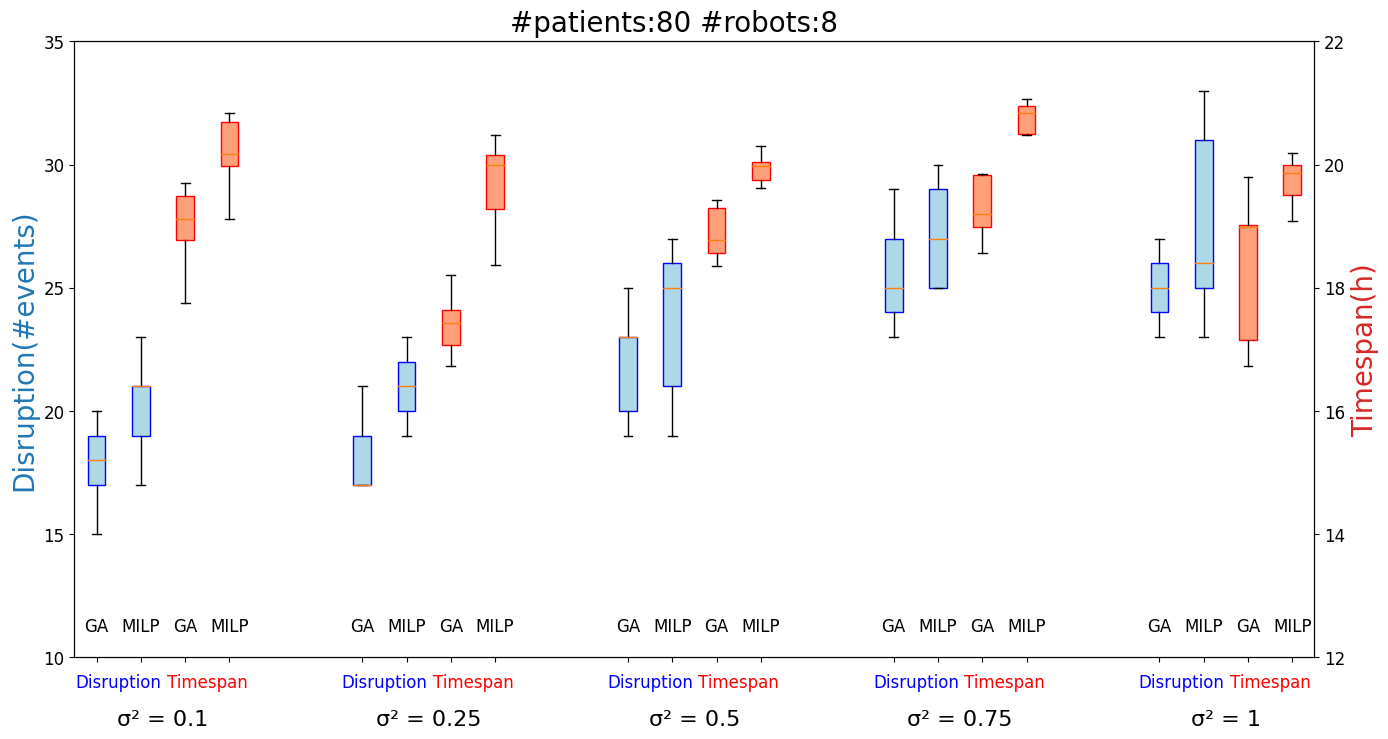

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Datos de ejemplo
num_datasets = 5  # Número de conjuntos de datos
genetico_coste_data = [
    [17, 20, 19, 18, 15],
    [19, 21, 17, 17, 17],
    [20, 19, 23, 25, 23],
    [23, 24, 29, 25, 27],
    [27, 25, 26, 23, 24]
]

milp_coste_data = [
    [19, 21, 21, 17, 23],
    [19, 20, 23, 21, 22],
    [19, 21, 26, 25, 27],
    [27, 25, 30, 25, 29],
    [26, 25, 31, 23, 33]
]


genetico_timespan_data = [
    [17.75, 18.775, 19.485, 19.695, 19.115],
    [18.2, 16.725, 17.435, 17.645, 17.065],
    [19.425, 18.355, 18.775, 19.3, 18.565],
    [19.85, 19.825, 18.985, 19.195, 18.565],
    [19.8, 16.725, 18.985, 17.145, 19.02]
]

milp_timespan_data = [
    [19.12, 20.175, 19.976, 20.69, 20.832],
    [20.155, 18.364, 19.274, 20.476, 19.996],
    [19.976, 20.304, 19.62, 20.035, 19.744],
    [20.832, 20.49, 20.944, 21.058, 20.476],
    [20.19, 19.085, 19.869, 19.513, 19.996]
]

# Configuración del gráfico
fig, axs = plt.subplots(1, 1, figsize=(16, 8))

# Crear un segundo eje y para timespan en el lado derecho
ax2 = axs.twinx()

# Posiciones para los boxplots
positions_genetico_coste = np.arange(1, 3 * num_datasets * 2, step=6)
positions_milp_coste = np.arange(2, 3 * num_datasets * 2 + 1, step=6)

# Boxplots para el coste en el eje izquierdo
bp1 = axs.boxplot(genetico_coste_data, positions=positions_genetico_coste, labels=[f' ' for i in range(num_datasets)], widths=0.4, patch_artist=True)
bp1_milp = axs.boxplot(milp_coste_data, positions=positions_milp_coste, labels=[f' ' for i in range(num_datasets)], widths=0.4, patch_artist=True)

axs.set_ylabel('Disruption(#events)', fontsize=20, color='tab:blue')
axs.set_ylim([10, 35])  # Ajusta el rango según tus datos

# Colorea los boxplots de coste para genetico
colors_genetico_coste = ['lightblue'] * num_datasets
for box, color in zip(bp1['boxes'], colors_genetico_coste):
    box.set(color='blue', facecolor=color)

# Colorea los boxplots de coste para milp
colors_milp_coste = ['lightblue'] * num_datasets
for box, color in zip(bp1_milp['boxes'], colors_milp_coste):
    box.set(color='blue', facecolor=color)

# Posiciones para los boxplots de timespan
positions_genetico_timespan = np.arange(3, 3 * num_datasets * 2, step=6)
positions_milp_timespan = np.arange(4, 3 * num_datasets * 2 + 1, step=6)

# Boxplots para timespan en el lado derecho
bp2_genetico = ax2.boxplot(genetico_timespan_data, positions=positions_genetico_timespan, labels=[f' ' for i in range(num_datasets)], widths=0.4, patch_artist=True)
bp2_milp = ax2.boxplot(milp_timespan_data, positions=positions_milp_timespan, labels=[f' ' for i in range(num_datasets)], widths=0.4, patch_artist=True)

ax2.set_ylabel('Timespan(h)', fontsize=20, color='tab:red')
ax2.set_ylim([12, 22])  # Ajusta el rango según tus datos

# Colorea los boxplots de timespan para genetico
colors_genetico_timespan = ['lightsalmon'] * num_datasets
for box, color in zip(bp2_genetico['boxes'], colors_genetico_timespan):
    box.set(color='red', facecolor=color)

# Colorea los boxplots de timespan para milp
colors_milp_timespan = ['lightsalmon'] * num_datasets
for box, color in zip(bp2_milp['boxes'], colors_milp_timespan):
    box.set(color='red', facecolor=color)

for i in range(0, 30, 6):
    ax2.text(i+1, 12.5, 'GA', ha='center', va='center', fontsize=12, color='black')
    ax2.text(i+2, 12.5, 'MILP', ha='center', va='center', fontsize=12, color='black')
    ax2.text(i+3, 12.5, 'GA', ha='center', va='center', fontsize=12, color='black')
    ax2.text(i+4, 12.5, 'MILP', ha='center', va='center', fontsize=12, color='black')

for i in range(0, 30, 6):
    ax2.text(i+1.5, 11.6, 'Disruption', ha='center', va='center', fontsize=12, color='blue')
    ax2.text(i+3.5, 11.6, 'Timespan', ha='center', va='center', fontsize=12, color='red')

for i in range(0, 30, 6):
    if i==0:
      ax2.text(i+2.5, 11, 'σ² = 0.1', ha='center', va='center', fontsize=16, color='black')
    elif i==6:
      ax2.text(i+2.5, 11, 'σ² = 0.25', ha='center', va='center', fontsize=16, color='black')
    elif i==12:
      ax2.text(i+2.5, 11, 'σ² = 0.5', ha='center', va='center', fontsize=16, color='black')
    elif i==18:
      ax2.text(i+2.5, 11, 'σ² = 0.75', ha='center', va='center', fontsize=16, color='black')
    elif i==24:
      ax2.text(i+2.5, 11, 'σ² = 1', ha='center', va='center', fontsize=16, color='black')

# Añadir título superior
plt.suptitle('#patients:80 #robots:8', fontsize=20, y=0.92)

# Ajusta el tamaño de las etiquetas de los ejes
axs.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)

plt.savefig('Grafica_RQ1b_Robots80.pdf', format='pdf')
plt.show()

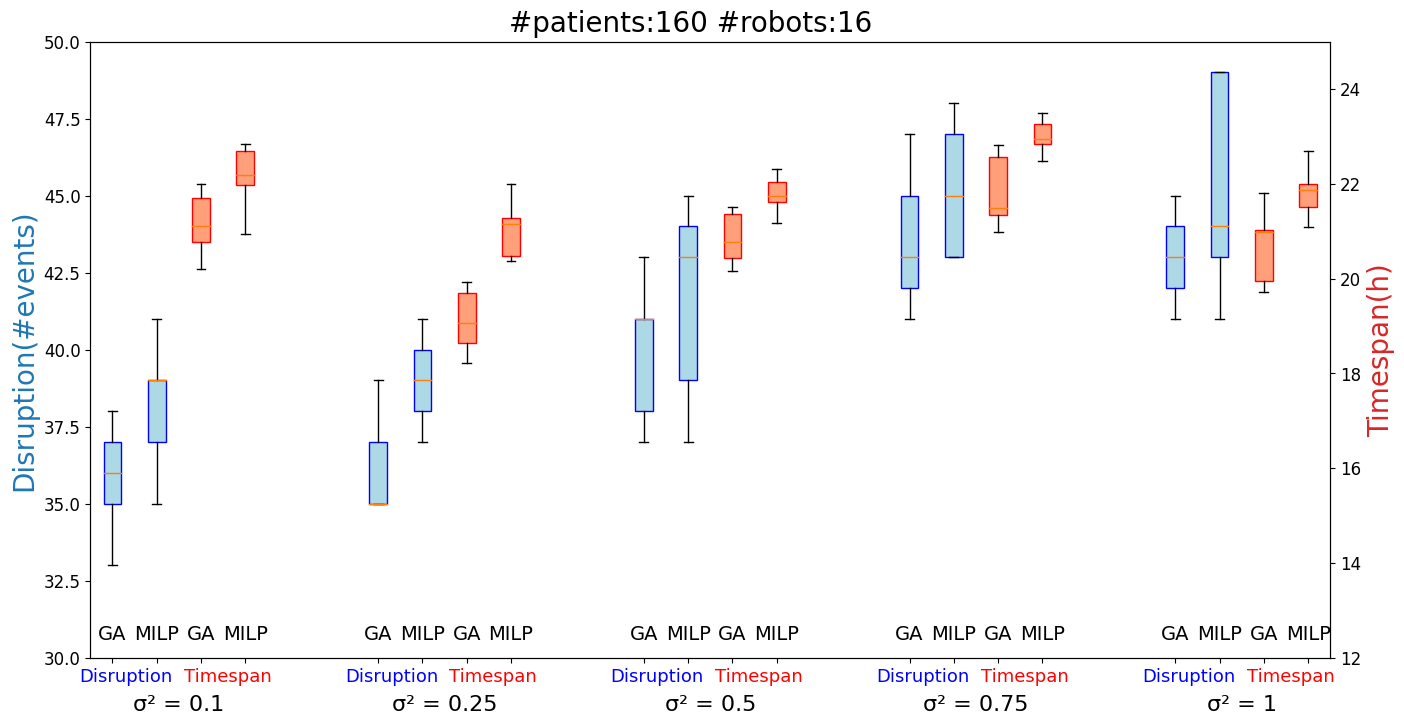

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Datos de ejemplo
num_datasets = 5  # Número de conjuntos de datos
genetico_coste_data = [
    [35, 38, 37, 36, 33],
    [37, 39, 35, 35, 35],
    [38, 37, 41, 43, 41],
    [41, 42, 47, 43, 45],
    [45, 43, 44, 41, 42]
]

milp_coste_data = [
    [37, 39, 39, 35, 41],
    [37, 38, 41, 39, 40],
    [37, 39, 44, 43, 45],
    [45, 43, 48, 43, 47],
    [44, 43, 49, 41, 49]
]


genetico_timespan_data = [
    [20.2, 20.775, 21.985, 21.695, 21.115],
    [19.7, 18.225, 19.935, 18.645, 19.065],
    [20.425, 21.355, 20.775, 21.5, 20.165],
    [21.35, 22.825, 20.985, 21.495, 22.565],
    [21.8, 19.725, 20.985, 19.945, 21.02]
]

milp_timespan_data = [
    [20.95, 22.175, 21.976, 22.69, 22.832],
    [21.155, 20.364, 21.274, 20.476, 21.996],
    [21.176, 22.304, 21.62, 22.035, 21.744],
    [22.832, 23.49, 22.944, 23.258, 22.476],
    [21.99, 21.085, 21.869, 21.513, 22.696]
]

# Configuración del gráfico
fig, axs = plt.subplots(1, 1, figsize=(16, 8))

# Crear un segundo eje y para timespan en el lado derecho
ax2 = axs.twinx()

# Posiciones para los boxplots
positions_genetico_coste = np.arange(1, 3 * num_datasets * 2, step=6)
positions_milp_coste = np.arange(2, 3 * num_datasets * 2 + 1, step=6)

# Boxplots para el coste en el eje izquierdo
bp1 = axs.boxplot(genetico_coste_data, positions=positions_genetico_coste, labels=[f' ' for i in range(num_datasets)], widths=0.4, patch_artist=True)
bp1_milp = axs.boxplot(milp_coste_data, positions=positions_milp_coste, labels=[f' ' for i in range(num_datasets)], widths=0.4, patch_artist=True)

axs.set_ylabel('Disruption(#events)', fontsize=20, color='tab:blue')
axs.set_ylim([30, 50])  # Ajusta el rango según tus datos

# Colorea los boxplots de coste para genetico
colors_genetico_coste = ['lightblue'] * num_datasets
for box, color in zip(bp1['boxes'], colors_genetico_coste):
    box.set(color='blue', facecolor=color)

# Colorea los boxplots de coste para milp
colors_milp_coste = ['lightblue'] * num_datasets
for box, color in zip(bp1_milp['boxes'], colors_milp_coste):
    box.set(color='blue', facecolor=color)

# Posiciones para los boxplots de timespan
positions_genetico_timespan = np.arange(3, 3 * num_datasets * 2, step=6)
positions_milp_timespan = np.arange(4, 3 * num_datasets * 2 + 1, step=6)

# Boxplots para timespan en el lado derecho
bp2_genetico = ax2.boxplot(genetico_timespan_data, positions=positions_genetico_timespan, labels=[f' ' for i in range(num_datasets)], widths=0.4, patch_artist=True)
bp2_milp = ax2.boxplot(milp_timespan_data, positions=positions_milp_timespan, labels=[f' ' for i in range(num_datasets)], widths=0.4, patch_artist=True)

ax2.set_ylabel('Timespan(h)', fontsize=20, color='tab:red')
ax2.set_ylim([12, 25])  # Ajusta el rango según tus datos

# Ajusta el tamaño de fuente de los números de la escala en el eje y
axs.tick_params(axis='y', labelsize=14)  # Puedes ajustar el tamaño '14' según tus preferencias


# Colorea los boxplots de timespan para genetico
colors_genetico_timespan = ['lightsalmon'] * num_datasets
for box, color in zip(bp2_genetico['boxes'], colors_genetico_timespan):
    box.set(color='red', facecolor=color)

# Colorea los boxplots de timespan para milp
colors_milp_timespan = ['lightsalmon'] * num_datasets
for box, color in zip(bp2_milp['boxes'], colors_milp_timespan):
    box.set(color='red', facecolor=color)

for i in range(0, 30, 6):
    ax2.text(i+1, 12.5, 'GA', ha='center', va='center', fontsize=14, color='black')
    ax2.text(i+2, 12.5, 'MILP', ha='center', va='center', fontsize=14, color='black')
    ax2.text(i+3, 12.5, 'GA', ha='center', va='center', fontsize=14, color='black')
    ax2.text(i+4, 12.5, 'MILP', ha='center', va='center', fontsize=14, color='black')

for i in range(0, 30, 6):
    ax2.text(i+1.3, 11.6, 'Disruption', ha='center', va='center', fontsize=13, color='blue')
    ax2.text(i+3.6, 11.6, 'Timespan', ha='center', va='center', fontsize=13, color='red')

for i in range(0, 30, 6):
    if i==0:
      ax2.text(i+2.5, 11, 'σ² = 0.1', ha='center', va='center', fontsize=16, color='black')
    elif i==6:
      ax2.text(i+2.5, 11, 'σ² = 0.25', ha='center', va='center', fontsize=16, color='black')
    elif i==12:
      ax2.text(i+2.5, 11, 'σ² = 0.5', ha='center', va='center', fontsize=16, color='black')
    elif i==18:
      ax2.text(i+2.5, 11, 'σ² = 0.75', ha='center', va='center', fontsize=16, color='black')
    elif i==24:
      ax2.text(i+2.5, 11, 'σ² = 1', ha='center', va='center', fontsize=16, color='black')





# Añadir título superior
plt.suptitle('#patients:160 #robots:16', fontsize=20, y=0.92)

# Ajusta el tamaño de las etiquetas de los ejes
axs.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)

plt.savefig('Grafica_RQ1b_Robots160.pdf', format='pdf')
plt.show()